# Interpretable AI for Deep Learning Models
###### ARI3205-SEM1-A-2526
### Proffessor: Konstantinos Makantasis
##### Authors: Love Carlander Strandang (2513558), Edvin Sanfridsson (2515058)



# 0.0 Setup

This section contains:
- Imports + environment info
- Reproducibility (seeds)
- Generic training loops (tabular + vision)
- Metrics + plotting utilities
- Model definitions (Tabular NN + CNN)
- Small wrappers to make PyTorch models compatible with interpretability libraries

## 0.1 Setup and Imports
### 0.1.1 Imports

In [ ]:
import json
import pickle
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from captum.attr import IntegratedGradients
from matplotlib import colors as matplotlib_colors
import torch.nn.functional as torch_functional
import tensorflow as tf
from tensorflow import keras


from sklearn.metrics import roc_auc_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_text


mpl.rcParams.update({
    "figure.facecolor": "#2b2b2b",  # outside of axes
    "axes.facecolor": "#2b2b2b",    # plot area
    "savefig.facecolor": "#2b2b2b",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "text.color": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "#555555",
})


/Users/nordh/Documents/Software-Engineering-and-Managment-GU/MALTA/Courses/Interperatable AI/Interperatable/.venv311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 0.1.2 Reproducibility 
We set a seed for random so that we will get cosistent reproducable results

In [ ]:
RANDOM_SEED = 1337
np.random.seed(RANDOM_SEED)

### 0.1.3 Setup Root Repo

In [ ]:
current_working_directory = Path.cwd()
repo_root_directory = current_working_directory.parent

if str(repo_root_directory) not in sys.path:
    sys.path.insert(0, str(repo_root_directory))

print("Repo root added to sys.path:", repo_root_directory)

artifacts_root_directory = repo_root_directory / "artifacts"

adult_artifacts_directory = artifacts_root_directory / "train_all" / "adult_mlp"
california_artifacts_directory = artifacts_root_directory / "train_all" / "california_mlp"
fashion_artifacts_directory = artifacts_root_directory / "train_all" / "fashion_cnn"

print("CWD:", current_working_directory)
print("Repo root:", repo_root_directory)
print("Artifacts root exists?", artifacts_root_directory.exists())
print("Adult artifacts exists?", adult_artifacts_directory.exists())
print("California artifacts exists?", california_artifacts_directory.exists())
print("Fashion artifacts exists?", fashion_artifacts_directory.exists())



Repo root added to sys.path: /Users/nordh/Documents/Software-Engineering-and-Managment-GU/MALTA/Courses/Interperatable AI/Interperatable
CWD: /Users/nordh/Documents/Software-Engineering-and-Managment-GU/MALTA/Courses/Interperatable AI/Interperatable/notebooks
Repo root: /Users/nordh/Documents/Software-Engineering-and-Managment-GU/MALTA/Courses/Interperatable AI/Interperatable
Artifacts root exists? True
Adult artifacts exists? True
California artifacts exists? True
Fashion artifacts exists? True


## 0.2 Load Trained Models

### 0.2.1 Adult
We have trained the

In [ ]:
adult_model_path = adult_artifacts_directory / "best_model.keras"
adult_preprocessor_path = adult_artifacts_directory / "preprocessing.pkl"
adult_feature_names_path = adult_artifacts_directory / "expanded_feature_names.json"

adult_model = keras.models.load_model(adult_model_path)

with open(adult_preprocessor_path, "rb") as file_handle:
    adult_preprocessor = pickle.load(file_handle)

adult_expanded_feature_names = json.loads(adult_feature_names_path.read_text())


#TODO add print statements for loading the models

#### Prediction Wrappers

In [ ]:
def predict_adult_positive_probability(features_dataframe: pd.DataFrame) -> np.ndarray:
    processed_features = adult_preprocessor.transform(features_dataframe)
    probability = adult_model.predict(processed_features, verbose=0).reshape(-1)
    return probability

def predict_adult_label(features_dataframe: pd.DataFrame, threshold: float = 0.5) -> np.ndarray:
    probability = predict_adult_positive_probability(features_dataframe)
    return (probability >= threshold).astype(int)

### 0.2.2 California (Keras regressor + numeric preprocessor)

In [ ]:
california_model_path = california_artifacts_directory / "best_model.keras"
california_preprocessor_path = california_artifacts_directory / "preprocessing.pkl"
california_feature_names_path = california_artifacts_directory / "feature_names.json"

california_model = keras.models.load_model(california_model_path)

with open(california_preprocessor_path, "rb") as file_handle:
    california_preprocessor = pickle.load(file_handle)

california_feature_names = json.loads(california_feature_names_path.read_text())

#TODO add print statements for loading the models


In [ ]:
def predict_california_value(features_dataframe: pd.DataFrame) -> np.ndarray:
    processed_features = california_preprocessor.transform(features_dataframe)
    prediction = california_model.predict(processed_features, verbose=0).reshape(-1)
    return prediction


### 0.2.3 Fashion CNN (PyTorch)

In [ ]:
import torch
from src.models.fashion_cnn import FashionCNN
from src.data.fashion import load_fashion, FASHION_MNIST_CLASS_NAMES

fashion_weights_path = fashion_artifacts_directory / "best_model.pt"

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

cpu_device = torch.device("cpu")

fashion_model_cpu = FashionCNN(class_count=len(FASHION_MNIST_CLASS_NAMES)).to(cpu_device).float()
fashion_model_cpu.load_state_dict(torch.load(fashion_weights_path, map_location=cpu_device))
fashion_model_cpu.eval()

fashion_train_dataset, fashion_test_dataset = load_fashion(normalize=False) 

print("Loaded Fashion-MNIST test size:", len(fashion_test_dataset))
print("Weights found?", fashion_weights_path.exists())
print("Device:", device)

Loaded Fashion-MNIST test size: 10000
Weights found? True
Device: mps


#### 0.2.3.1 get prediction and correct examples

In [ ]:
def get_model_device(model: torch.nn.Module) -> torch.device:
    return next(model.parameters()).device


def get_predicted_class_and_probabilities(
    model: torch.nn.Module,
    input_tensor: torch.Tensor,  # shape (1, 1, 28, 28)
) -> tuple[int, np.ndarray]:
    model.eval()

    model_device = get_model_device(model)
    input_tensor = input_tensor.to(device=model_device, dtype=torch.float32)

    with torch.no_grad():
        logits = model(input_tensor)
        probabilities = torch_functional.softmax(logits, dim=1)[0].detach().cpu().numpy()
        predicted_class_index = int(np.argmax(probabilities))
    return predicted_class_index, probabilities


def fetch_correct_examples(
    model: torch.nn.Module,
    dataset,
    example_count: int = 5,
) -> list[dict]:
    collected_examples: list[dict] = []
    model_device = get_model_device(model)

    for sample_index in range(len(dataset)):
        image_tensor, true_label = dataset[sample_index]  # expected (1, 28, 28)

        # Keep a CPU copy (useful later for Captum on CPU)
        input_tensor_cpu = image_tensor.unsqueeze(0).to(device="cpu", dtype=torch.float32)

        # Also create a model-device version for prediction (MPS or CPU)
        input_tensor_for_prediction = input_tensor_cpu.to(device=model_device)

        predicted_class_index, probabilities = get_predicted_class_and_probabilities(
            model=model,
            input_tensor=input_tensor_for_prediction,
        )

        if predicted_class_index == int(true_label):
            collected_examples.append(
                {
                    "input_tensor_cpu": input_tensor_cpu,  # best for Captum CPU IG
                    "true_label": int(true_label),
                    "predicted_class": predicted_class_index,
                    "probabilities": probabilities,
                }
            )

        if len(collected_examples) >= example_count:
            break

    return collected_examples

fashion_examples = fetch_correct_examples(fashion_model_cpu, fashion_test_dataset, example_count=5)

for i, example in enumerate(fashion_examples, start=1):
    true_name = FASHION_MNIST_CLASS_NAMES[example["true_label"]]
    pred_name = FASHION_MNIST_CLASS_NAMES[example["predicted_class"]]
    pred_prob = example["probabilities"][example["predicted_class"]]
    print(f"Example {i}: true={true_name}, predicted={pred_name}, prob={pred_prob:.3f}")


Example 1: true=Ankle boot, predicted=Ankle boot, prob=0.999
Example 2: true=Pullover, predicted=Pullover, prob=1.000
Example 3: true=Trouser, predicted=Trouser, prob=1.000
Example 4: true=Trouser, predicted=Trouser, prob=1.000
Example 5: true=Shirt, predicted=Shirt, prob=0.936


#### 0.2.3.2 get incorrect examples
Finds a small set of misclassified examples from the dataset.

In [ ]:
def fetch_misclassified_examples(
    model: torch.nn.Module,
    dataset,
    example_count: int = 5,
) -> list[dict]:
    collected_examples: list[dict] = []
    model_device = next(model.parameters()).device

    for sample_index in range(len(dataset)):
        image_tensor, true_label = dataset[sample_index]  # expected (1, 28, 28)

        input_tensor_cpu = image_tensor.unsqueeze(0).to(device="cpu", dtype=torch.float32)
        input_tensor_for_prediction = input_tensor_cpu.to(device=model_device)

        predicted_class_index, probabilities = get_predicted_class_and_probabilities(
            model=model,
            input_tensor=input_tensor_for_prediction,
        )

        if predicted_class_index != int(true_label):
            collected_examples.append(
                {
                    "input_tensor_cpu": input_tensor_cpu,
                    "true_label": int(true_label),
                    "predicted_class": predicted_class_index,
                    "probabilities": probabilities,
                }
            )

        if len(collected_examples) >= example_count:
            break

    return collected_examples


# Example usage:
fashion_misclassified_examples = fetch_misclassified_examples(
    model=fashion_model_cpu,
    dataset=fashion_test_dataset,
    example_count=5,
)

for i, example in enumerate(fashion_misclassified_examples, start=1):
    true_name = FASHION_MNIST_CLASS_NAMES[example["true_label"]]
    pred_name = FASHION_MNIST_CLASS_NAMES[example["predicted_class"]]
    pred_prob = example["probabilities"][example["predicted_class"]]
    print(f"Misclassified {i}: true={true_name}, predicted={pred_name}, prob={pred_prob:.3f}")


Misclassified 1: true=Sneaker, predicted=Sandal, prob=0.507
Misclassified 2: true=Ankle boot, predicted=Sandal, prob=1.000
Misclassified 3: true=Coat, predicted=Shirt, prob=0.598
Misclassified 4: true=Shirt, predicted=T-shirt/top, prob=0.511
Misclassified 5: true=Dress, predicted=Shirt, prob=0.578


## 0.3 Load test splits

### 0.3.1 Adult splits

In [ ]:
from src.data.adult import load_adult_splits

adult_train_df, adult_val_df, adult_test_df, y_train, y_val, y_test, adult_meta = load_adult_splits(
    random_state=RANDOM_SEED
)

### 0.3.2 Calefornia Splits

In [ ]:
from src.data.california import load_california

cal_train_df, cal_val_df, cal_test_df, cal_y_train, cal_y_val, cal_y_test = load_california(
    random_state=RANDOM_SEED
)

### 0.3.3 Sanity check

In [ ]:
adult_test_probs = predict_adult_positive_probability(adult_test_df)
adult_test_pred = (adult_test_probs >= 0.5).astype(int)
print("Adult test accuracy:", accuracy_score(y_test, adult_test_pred))
print("Adult test AUC:", roc_auc_score(y_test, adult_test_probs))

cal_test_pred = predict_california_value(cal_test_df)
print("California test MAE:", mean_absolute_error(cal_y_test, cal_test_pred))

Adult test accuracy: 0.8469648889343843
Adult test AUC: 0.9041485919101298
California test MAE: 0.7705781851208555


# 1. Part 1: Feature-Level Interpretability (30 marks)
---

We analyze feature-level interpretability for the tabular models:
- Adult (binary classification) using predicted probability of income > 50K
- California Housing (regression) using predicted median house value

Methods included:
1) PDP + ICE (at least 2 features per dataset)
2) Permutation Feature Importance (PFI)
3) ALE (at least 2 features per dataset)
4) Global surrogate model (interpretability + fidelity discussion)

## 1.1 Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE) plots 
---
## 1.1.1 helper to compute ICE + PDP data

In [ ]:

def compute_ice_and_pdp_curves(
    features_dataframe: pd.DataFrame,
    prediction_function,
    feature_name: str,
    grid_point_count: int = 25,
    ice_line_count: int = 50,
    sampling_row_count: int = 1000,
    random_seed: int = RANDOM_SEED,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Returns:
      grid_values: shape (grid_point_count,)
      ice_matrix: shape (ice_line_count, grid_point_count)
      pdp_values: shape (grid_point_count,)
    """
    if feature_name not in features_dataframe.columns:
        raise ValueError(f"Feature '{feature_name}' not found in dataframe columns.")

    sampled_dataframe = features_dataframe.sample(
        n=min(sampling_row_count, len(features_dataframe)),
        random_state=random_seed,
    ).reset_index(drop=True)

    ice_source_dataframe = sampled_dataframe.sample(
        n=min(ice_line_count, len(sampled_dataframe)),
        random_state=random_seed,
    ).reset_index(drop=True)

    feature_values = sampled_dataframe[feature_name].dropna().values
    grid_min_value = float(np.quantile(feature_values, 0.05))
    grid_max_value = float(np.quantile(feature_values, 0.95))
    grid_values = np.linspace(grid_min_value, grid_max_value, grid_point_count)

    ice_matrix = np.zeros((len(ice_source_dataframe), len(grid_values)), dtype=float)

    for grid_index, grid_value in enumerate(grid_values):
        modified_dataframe = ice_source_dataframe.copy()
        modified_dataframe[feature_name] = grid_value
        ice_matrix[:, grid_index] = prediction_function(modified_dataframe)

    pdp_values = ice_matrix.mean(axis=0)
    return grid_values, ice_matrix, pdp_values


### 1.1.2 Function to PDP plots

In [ ]:
def plot_pdp_only(
    grid_values: np.ndarray,
    pdp_values: np.ndarray,
    feature_name: str,
    y_axis_label: str,
) -> None:
    plt.figure(figsize=(8, 4))
    plt.plot(grid_values, pdp_values, linewidth=3)
    plt.title(f"PDP (average effect) — {feature_name}")
    plt.xlabel(feature_name)
    plt.ylabel(y_axis_label)
    plt.tight_layout()
    plt.show()


### 1.1.3 Function for ICE plots

In [ ]:
def plot_ice_only(
    grid_values: np.ndarray,
    ice_matrix: np.ndarray,
    feature_name: str,
    y_axis_label: str,
) -> None:
    plt.figure(figsize=(8, 4))
    for row_index in range(ice_matrix.shape[0]):
        plt.plot(grid_values, ice_matrix[row_index, :], alpha=0.25)
    plt.title(f"ICE (individual predictions) — {feature_name}")
    plt.xlabel(feature_name)
    plt.ylabel(y_axis_label)
    plt.tight_layout()
    plt.show()


### 1.1.4 Adult (pick 2 features)

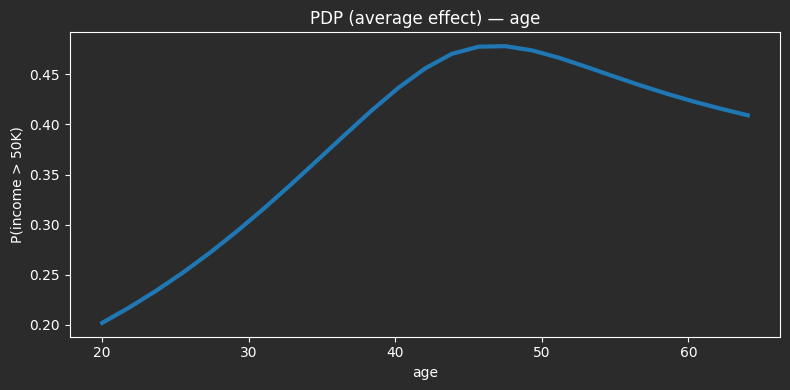

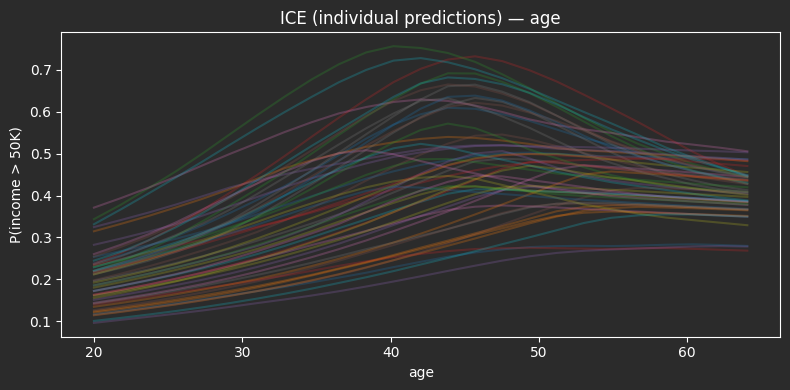

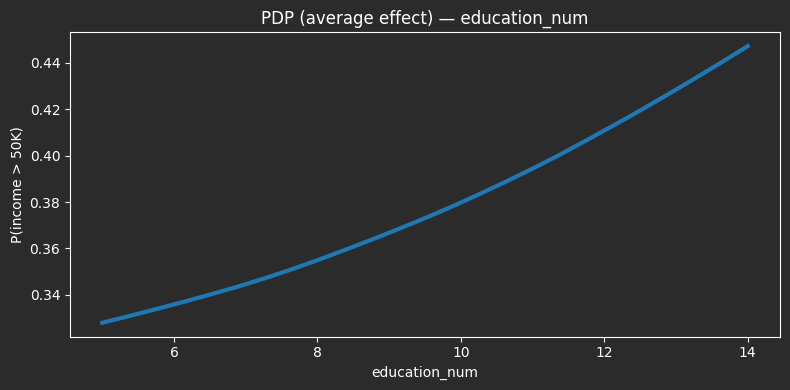

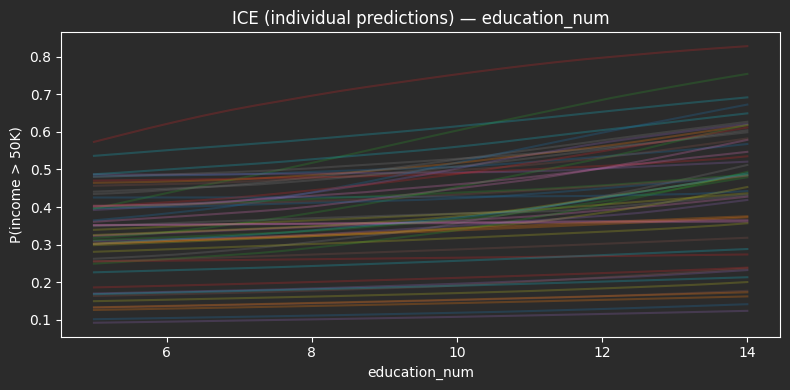

In [ ]:
adult_features_for_pdp_ice = ["age", "education_num"] 

for feature_name in adult_features_for_pdp_ice:
    grid_values, ice_matrix, pdp_values = compute_ice_and_pdp_curves(
        features_dataframe=adult_test_df,
        prediction_function=predict_adult_positive_probability,
        feature_name=feature_name,
        grid_point_count=25,
        ice_line_count=50,
        random_seed=RANDOM_SEED,
    )

    plot_pdp_only(grid_values, pdp_values, feature_name, y_axis_label="P(income > 50K)")
    plot_ice_only(grid_values, ice_matrix, feature_name, y_axis_label="P(income > 50K)")


### 1.1.5 California (pick 2 features)

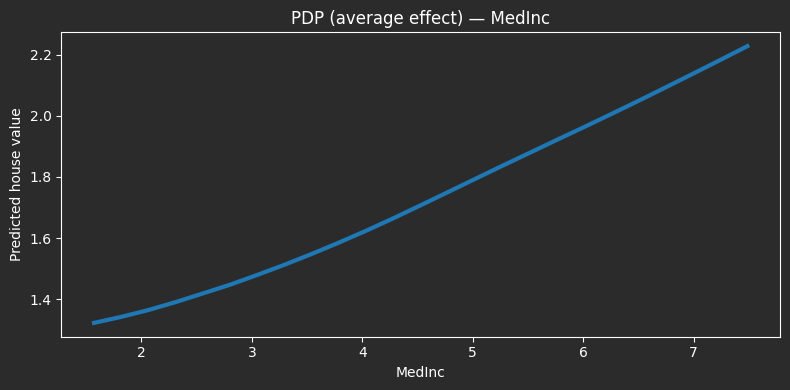

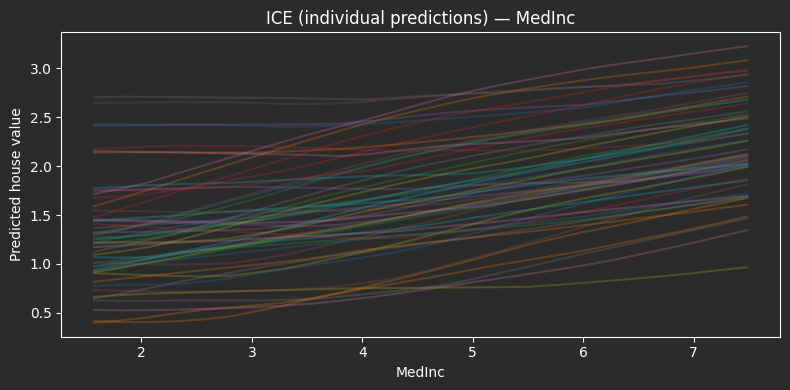

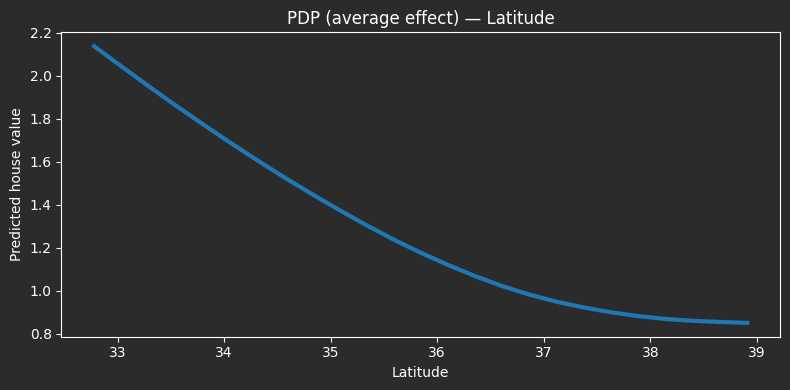

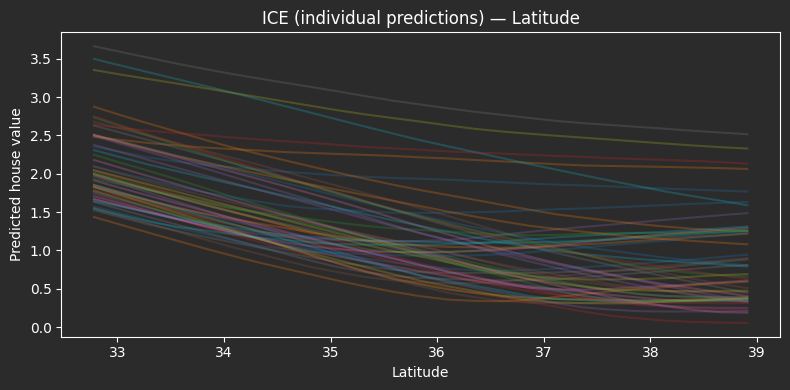

In [ ]:
california_features_for_pdp_ice = ["MedInc", "Latitude"] 

for feature_name in california_features_for_pdp_ice:
    grid_values, ice_matrix, pdp_values = compute_ice_and_pdp_curves(
        features_dataframe=cal_test_df,
        prediction_function=predict_california_value,
        feature_name=feature_name,
        grid_point_count=25,
        ice_line_count=50,
        random_seed=RANDOM_SEED,
    )

    plot_pdp_only(grid_values, pdp_values, feature_name, y_axis_label="Predicted house value")
    plot_ice_only(grid_values, ice_matrix, feature_name, y_axis_label="Predicted house value")


### 1.2 PDP and ICE — Insights about model behaviour

**California Housing (regression):**
- **MedInc:** The PDP shows a clear, monotonic increase: higher median income is associated with higher predicted house value. The ICE curves mostly rise as well, but with different slopes and vertical offsets. This indicates that the positive effect of income is consistent, but its *strength* varies by area/other features (interaction effects).
- **Latitude:** The PDP decreases strongly as latitude increases (from ~33 to ~39), meaning the model predicts higher house values in lower-latitude regions on average. The ICE curves show a similar downward trend for most individual samples, again with substantial spread. This suggests that location has a systematic effect, but the exact magnitude depends on other factors such as longitude, income, and neighborhood characteristics.

**Adult Census (classification):**
- **age:** The PDP is non-linear: the predicted probability of earning >50K increases from early adulthood up to roughly mid-career (around the mid-40s), then gradually declines at higher ages. The ICE curves vary widely—some individuals have a steep rise with age while others are flatter—indicating that age interacts with other attributes (e.g., education, work hours, occupation, capital gains).
- **education_num:** The PDP increases steadily with education level, indicating that higher education is associated with higher predicted income probability. ICE curves also generally increase, but with different slopes, suggesting heterogeneity: education helps across individuals, but the benefit is larger for some than others depending on their overall profile.

**What PDP vs ICE add:**
- **PDP** provides the *average marginal effect* of a feature across the dataset (global behaviour).
- **ICE** reveals *individual-level variation* and potential interactions: if the ICE lines fan out or cross, it suggests that the feature effect is not the same for everyone and depends on other features.
- In our results, MedInc and education_num show fairly consistent monotonic effects, whereas age shows a clearly non-linear average relationship and substantial individual variation.


## 1.2 Permutation Feature Importance (PFI)
---
### 1.2.1 Setting up PFI

In [ ]:
def compute_permutation_feature_importance(
    features_dataframe: pd.DataFrame,
    target_array: np.ndarray,
    prediction_function,
    scoring_function,
    permutation_repeat_count: int = 5,
    max_feature_count_to_show: int = 15,
    random_seed: int = RANDOM_SEED,
) -> pd.DataFrame:
    """
    Permutation Feature Importance (PFI):
    - Compute baseline score.
    - For each feature, shuffle its column, recompute score.
    - Importance = baseline_score - permuted_score (bigger means more important).
    """
    random_number_generator = np.random.default_rng(random_seed)

    baseline_predictions = prediction_function(features_dataframe)
    baseline_score = scoring_function(target_array, baseline_predictions)

    feature_importance_rows = []

    for feature_name in features_dataframe.columns:
        score_drops = []

        for _ in range(permutation_repeat_count):
            permuted_dataframe = features_dataframe.copy()
            permuted_dataframe[feature_name] = random_number_generator.permutation(
                permuted_dataframe[feature_name].values
            )

            permuted_predictions = prediction_function(permuted_dataframe)
            permuted_score = scoring_function(target_array, permuted_predictions)

            score_drops.append(baseline_score - permuted_score)

        feature_importance_rows.append(
            {
                "feature": feature_name,
                "importance_mean": float(np.mean(score_drops)),
                "importance_std": float(np.std(score_drops)),
            }
        )

    importance_dataframe = pd.DataFrame(feature_importance_rows).sort_values(
        "importance_mean", ascending=False
    )

    # Plot
    top_importance_dataframe = importance_dataframe.head(max_feature_count_to_show)

    plt.figure(figsize=(10, 5))
    plt.barh(
        top_importance_dataframe["feature"][::-1],
        top_importance_dataframe["importance_mean"][::-1],
        xerr=top_importance_dataframe["importance_std"][::-1],
    )
    plt.title("Permutation Feature Importance (Top Features)")
    plt.xlabel("Importance (baseline score - permuted score)")
    plt.tight_layout()
    plt.show()

    return importance_dataframe


### 1.2.2 (Adult PFI using AUC)

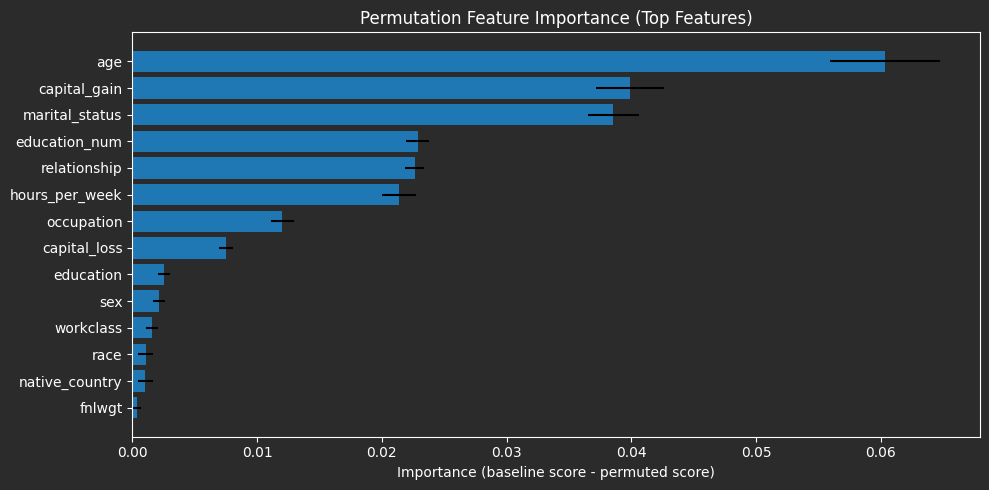

,feature,importance_mean,importance_std
0,age,0.060323,0.004378
10,capital_gain,0.039893,0.002700
5,marital_status,0.038556,0.002051
4,education_num,0.022878,0.000926
7,relationship,0.022623,0.000772
12,hours_per_week,0.021409,0.001354
6,occupation,0.012034,0.000919
11,capital_loss,0.007540,0.000547
3,education,0.002523,0.000480
9,sex,0.002140,0.000489


In [ ]:
sampled_adult_test_df = adult_test_df.sample(min(6000, len(adult_test_df)), random_state=RANDOM_SEED)

# If y_test is a pandas Series:
# Convert y_test to a Series aligned to adult_test_df's index, then select the sampled rows
adult_y_test_series = pd.Series(y_test, index=adult_test_df.index)
sampled_adult_y_test = adult_y_test_series.loc[sampled_adult_test_df.index].to_numpy()

adult_pfi_dataframe = compute_permutation_feature_importance(
    features_dataframe=sampled_adult_test_df,
    target_array=sampled_adult_y_test,
    prediction_function=predict_adult_positive_probability,
    scoring_function=roc_auc_score,
    permutation_repeat_count=10,
    max_feature_count_to_show=15,
    random_seed=RANDOM_SEED,
)

adult_pfi_dataframe.head(10)


### 1.2.3 California PFI using negative MAE

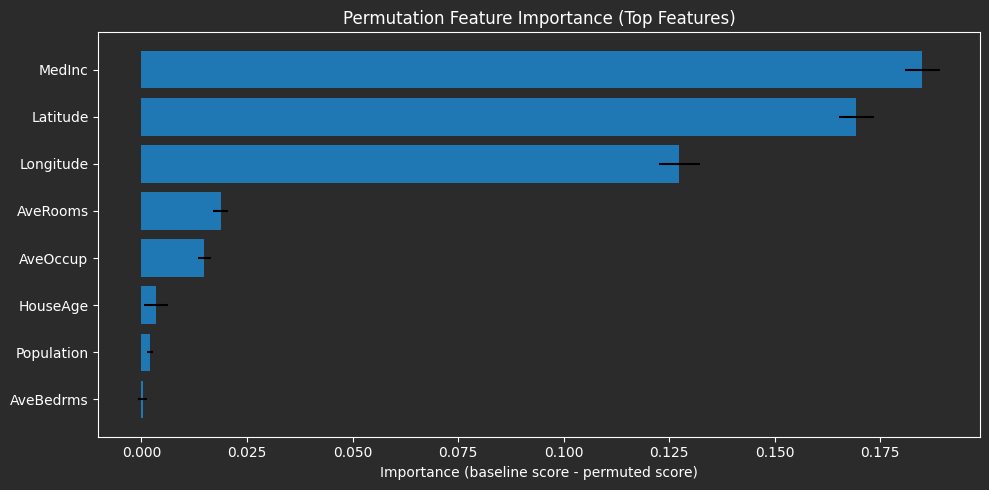

,feature,importance_mean,importance_std
0,MedInc,0.184934,0.004179
6,Latitude,0.169273,0.004122
7,Longitude,0.127407,0.004768
2,AveRooms,0.018819,0.001780
5,AveOccup,0.014934,0.001563
1,HouseAge,0.003395,0.002873
4,Population,0.002010,0.000796
3,AveBedrms,0.000353,0.001062


In [ ]:
def negative_mean_absolute_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return -mean_absolute_error(y_true, y_pred)

sampled_cal_test_df = cal_test_df.sample(
    n=min(6000, len(cal_test_df)),
    random_state=RANDOM_SEED,
)

cal_y_test_series = pd.Series(cal_y_test, index=cal_test_df.index)
sampled_cal_y_test = cal_y_test_series.loc[sampled_cal_test_df.index].to_numpy()

california_pfi_dataframe = compute_permutation_feature_importance(
    features_dataframe=sampled_cal_test_df,
    target_array=sampled_cal_y_test,
    prediction_function=predict_california_value,
    scoring_function=negative_mean_absolute_error,
    permutation_repeat_count=20,
    max_feature_count_to_show=15,
    random_seed=RANDOM_SEED,
)

california_pfi_dataframe.head(10)

### 1.2.4 Permutation Feature Importance (PFI) — Observations (updated)

**Adult (AUC-based PFI):**
- The most influential features are **age**, **capital_gain**, and **marital_status**, followed by **hours_per_week**, **relationship**, and **education_num**.
  - This is intuitive: higher income is often associated with **career stage (age)**, **investment-related signals (capital_gain)**, and **household/context variables (marital_status, relationship)**.
  - Work intensity (**hours_per_week**) and education level (**education_num**) also contribute strongly, which aligns with common economic patterns.
- Several features such as **occupation** and **capital_loss** have moderate importance, while others (e.g., **fnlwgt**, **native_country**) contribute relatively little in this model.
- Fairness note: **sex** and **race** appear but with comparatively small importance. These are still sensitive attributes, so we keep them in mind for later bias/fairness analysis.

---

**California Housing (negative MAE-based PFI):**
- **MedInc** is the single most important feature, with **Latitude** and **Longitude** also very strong.
  - This suggests the model relies heavily on **local income level** and **geographic location**, which is expected because housing prices vary both by region and by socio-economic conditions.
- After these, features like **AveRooms** and **AveOccup** have smaller but non-zero contributions, while others are near zero—indicating they add limited extra predictive power beyond income + location for this model.

**Interpretation & limitations:**
- PFI measures the **performance drop** when a feature is permuted, so it is a **global importance** measure rather than a causal statement.
- Results can be sensitive to randomness in the permutation process, so we use multiple repeats and report mean ± std. Correlated features (e.g., geographic variables or socio-economic proxies) can share importance, and some features may appear less important individually even if they matter jointly.


## 1.3 Accumulated Local Effects (ALE)
---
### 1.3.1 Helper function to calculate ALE and make plots

In [ ]:
def compute_ale_1d(
    features_dataframe: pd.DataFrame,
    prediction_function,
    feature_name: str,
    bin_count: int = 12,
    sampling_row_count: int = 3000,
    random_seed: int = RANDOM_SEED,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Manual 1D ALE for a numeric feature.

    Steps:
    1) Create quantile bins for the feature.
    2) For each bin [z_k, z_{k+1}), compute local effect:
         E[ f(x with feature=z_{k+1}) - f(x with feature=z_k) | x in bin ]
    3) Accumulate local effects across bins.
    4) Center the ALE curve to have mean ~ 0 (standard ALE convention).

    Returns:
      bin_midpoints, ale_values
    """
    if feature_name not in features_dataframe.columns:
        raise ValueError(f"Feature '{feature_name}' not found in dataframe columns.")

    # Sample for speed, but keep feature distribution representative
    working_dataframe = features_dataframe.sample(
        n=min(sampling_row_count, len(features_dataframe)),
        random_state=random_seed,
    ).copy()

    # Drop missing values for this feature
    working_dataframe = working_dataframe.dropna(subset=[feature_name]).copy()

    feature_values = working_dataframe[feature_name].to_numpy()

    # Quantile-based bin edges (robust to outliers)
    raw_bin_edges = np.quantile(feature_values, np.linspace(0.0, 1.0, bin_count + 1))
    bin_edges = np.unique(raw_bin_edges)  # ensure strictly increasing

    if len(bin_edges) < 3:
        raise ValueError(
            f"Not enough unique values in '{feature_name}' to compute ALE with bin_count={bin_count}."
        )

    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    local_effects = np.zeros(len(bin_midpoints), dtype=float)

    # Compute local effects per bin
    for bin_index, (lower_edge, upper_edge) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
        in_bin_mask = (working_dataframe[feature_name] >= lower_edge) & (working_dataframe[feature_name] < upper_edge)
        bin_dataframe = working_dataframe.loc[in_bin_mask]

        if len(bin_dataframe) == 0:
            local_effects[bin_index] = 0.0
            continue

        lower_dataframe = bin_dataframe.copy()
        upper_dataframe = bin_dataframe.copy()

        lower_dataframe[feature_name] = lower_edge
        upper_dataframe[feature_name] = upper_edge

        lower_predictions = prediction_function(lower_dataframe)
        upper_predictions = prediction_function(upper_dataframe)

        local_effects[bin_index] = float(np.mean(upper_predictions - lower_predictions))

    accumulated_effects = np.cumsum(local_effects)

    # Center ALE curve (standard convention)
    centered_ale = accumulated_effects - np.mean(accumulated_effects)

    return bin_midpoints, centered_ale


def plot_ale_1d(
    features_dataframe: pd.DataFrame,
    prediction_function,
    feature_name: str,
    bin_count: int = 12,
    sampling_row_count: int = 3000,
    random_seed: int = RANDOM_SEED,
    y_axis_label: str = "ALE",
) -> None:
    bin_midpoints, ale_values = compute_ale_1d(
        features_dataframe=features_dataframe,
        prediction_function=prediction_function,
        feature_name=feature_name,
        bin_count=bin_count,
        sampling_row_count=sampling_row_count,
        random_seed=random_seed,
    )

    plt.figure(figsize=(8, 4))
    plt.plot(bin_midpoints, ale_values, marker="o")
    plt.title(f"ALE (1D) — {feature_name}")
    plt.xlabel(feature_name)
    plt.ylabel(y_axis_label)
    plt.tight_layout()
    plt.show()


### 1.3.2 ALE for the same 2 features you used in PDP/ICE (Calefornia)

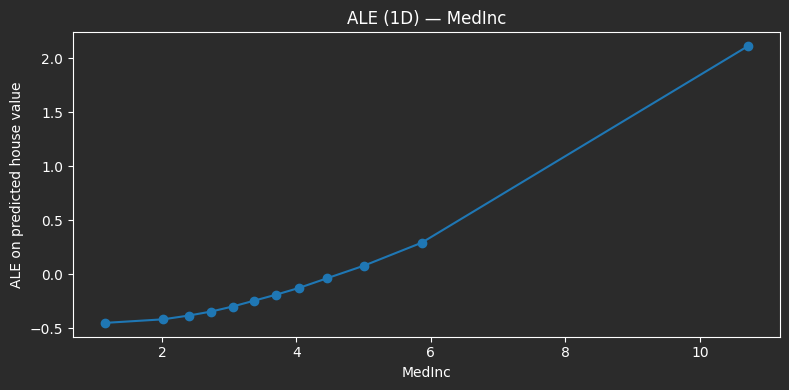

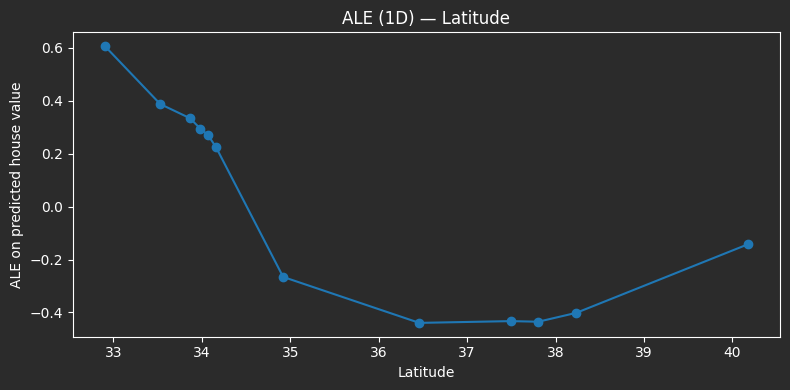

In [ ]:
california_features_for_ale = ["MedInc", "Latitude"]

for feature_name in california_features_for_ale:
    plot_ale_1d(
        features_dataframe=cal_test_df,
        prediction_function=predict_california_value,
        feature_name=feature_name,
        bin_count=12,
        sampling_row_count=3000,
        random_seed=RANDOM_SEED,
        y_axis_label="ALE on predicted house value",
    )


### 1.3.2 ALE for the same 2 features you used in PDP/ICE (Adult)

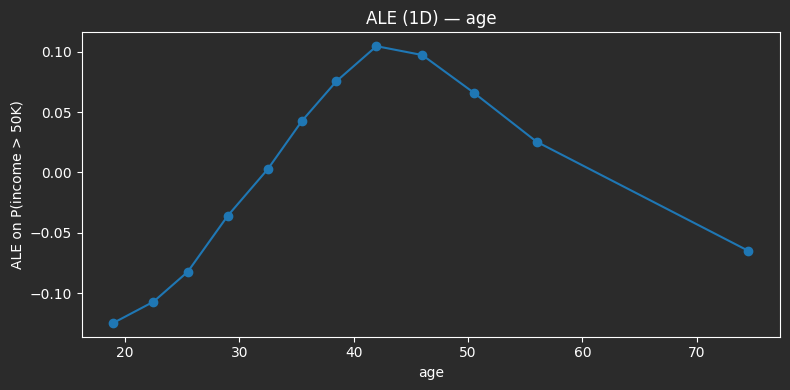

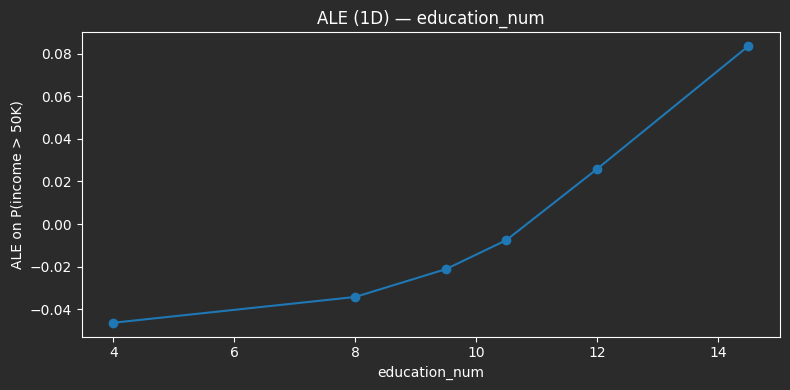

In [ ]:
adult_features_for_ale = ["age", "education_num"]

for feature_name in adult_features_for_ale:
    plot_ale_1d(
        features_dataframe=adult_test_df,
        prediction_function=predict_adult_positive_probability,
        feature_name=feature_name,
        bin_count=12,
        sampling_row_count=3000,
        random_seed=RANDOM_SEED,
        y_axis_label="ALE on P(income > 50K)",
    )


### 1.3.3 Compare PDP and ALE on same plot

To help with making a conclusion between the ALE and PDP we made methods that plot them together. 

In [ ]:
def compute_pdp_curve(
    features_dataframe: pd.DataFrame,
    prediction_function,
    feature_name: str,
    grid_point_count: int = 25,
    sampling_row_count: int = 1000,
    random_seed: int = RANDOM_SEED,
) -> tuple[np.ndarray, np.ndarray]:
    grid_values, ice_matrix, pdp_values = compute_ice_and_pdp_curves(
        features_dataframe=features_dataframe,
        prediction_function=prediction_function,
        feature_name=feature_name,
        grid_point_count=grid_point_count,
        ice_line_count=50,
        sampling_row_count=sampling_row_count,
        random_seed=random_seed,
    )
    return grid_values, pdp_values

def plot_ale_vs_pdp(
    features_dataframe: pd.DataFrame,
    prediction_function,
    feature_name: str,
    y_axis_label: str,
    random_seed: int = RANDOM_SEED,
) -> None:
    pdp_x, pdp_y = compute_pdp_curve(
        features_dataframe=features_dataframe,
        prediction_function=prediction_function,
        feature_name=feature_name,
        grid_point_count=25,
        sampling_row_count=2000,
        random_seed=random_seed,
    )

    ale_x, ale_y = compute_ale_1d(
        features_dataframe=features_dataframe,
        prediction_function=prediction_function,
        feature_name=feature_name,
        bin_count=12,
        sampling_row_count=3000,
        random_seed=random_seed,
    )

    # Normalize PDP to focus on *shape*
    pdp_y_centered = pdp_y - np.mean(pdp_y)

    plt.figure(figsize=(8, 4))
    plt.plot(pdp_x, pdp_y_centered, linewidth=3, label="PDP (centered)")
    plt.plot(ale_x, ale_y, marker="o", label="ALE")
    plt.title(f"ALE vs PDP — {feature_name} (shape comparison)")
    plt.xlabel(feature_name)
    plt.ylabel(y_axis_label)
    plt.legend()
    plt.tight_layout()
    plt.show()




### 1.3.4 Plot ALE and PDP together 

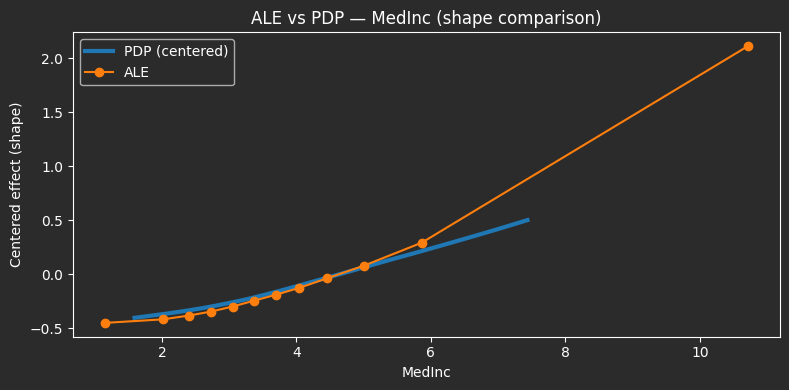

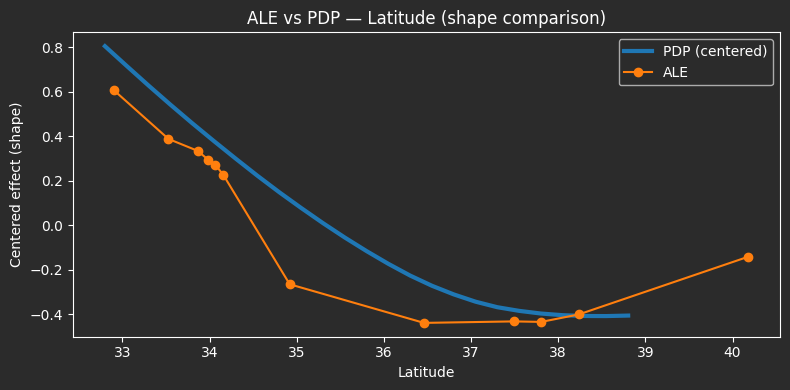

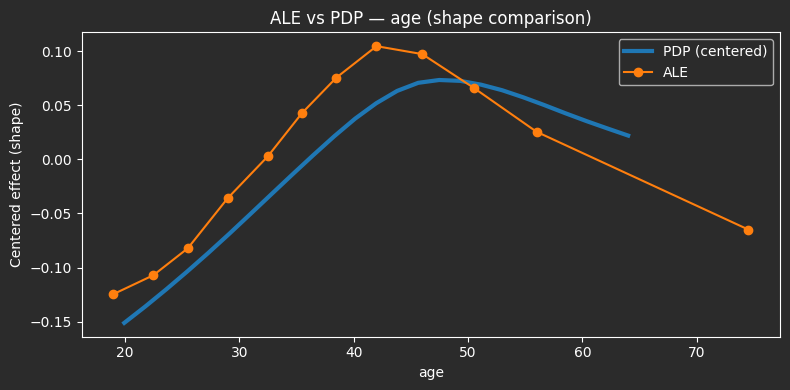

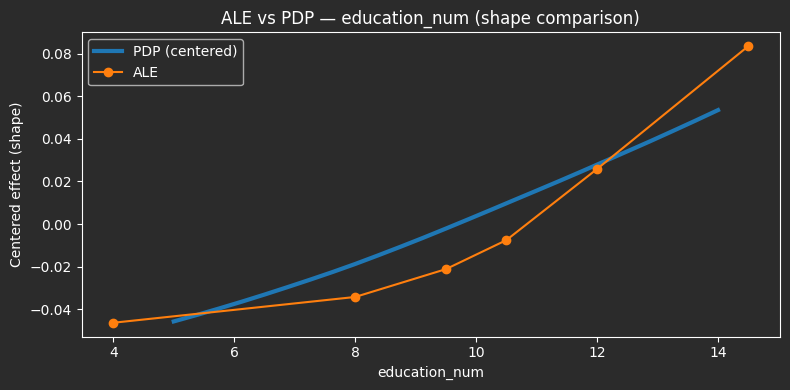

In [ ]:
for feature_name in ["MedInc", "Latitude"]:
    plot_ale_vs_pdp(
        features_dataframe=cal_test_df,
        prediction_function=predict_california_value,
        feature_name=feature_name,
        y_axis_label="Centered effect (shape)",
        random_seed=RANDOM_SEED,
    )

for feature_name in ["age", "education_num"]:
    plot_ale_vs_pdp(
        features_dataframe=adult_test_df,
        prediction_function=predict_adult_positive_probability,
        feature_name=feature_name,
        y_axis_label="Centered effect (shape)",
        random_seed=RANDOM_SEED,
    )


### 1.3.5 Accumulated Local Effects (ALE) — Results and comparison with PDP

**What ALE shows:**  
ALE measures *local* effects by looking at how the prediction changes when a feature moves within small intervals (bins), and then accumulating these changes. Unlike PDP, ALE only evaluates changes in regions where data actually exists, which makes it less sensitive to unrealistic feature combinations when features are correlated.

---

#### California Housing (MedInc, Latitude)

**MedInc:**
- Both **PDP** and **ALE** show a strong positive relationship: increasing median income increases predicted house value.
- The **ALE curve rises more sharply at higher MedInc values**, suggesting the model’s marginal effect of income becomes stronger in the upper income range (non-linear effect).
- Interpretatn: income is consistently important, and ALE indicates that the impact may accelerate for high-income areas.

**Latitude:**
- Both methods show a general **decrease** in predicted value as latitude increases (moving north), but the **ALE curve changes more abruptly** around mid-latitudes (roughly 34–36) and then flattens/partially recovers slightly at the highest latitudes.
- The larger difference between PDP and ALE for latitude is expected because **latitude is correlated with longitude and other regional variables**. PDP can be influenced by averaging over unrealistic combinations (e.g., holding latitude fixed while averaging over longitudes that don’t commonly occur at that latitude), while ALE stays closer to the observed data distribution.
- Interpretation: the latitude effect is real, but ALE suggests the model learns a more *local* “regional boundary” style effect rather than a perfectly smooth monotonic trend.

---

#### Adult Census (age, education_num)

**age:**
- Both PDP and ALE show a **non-linear** relationship: probability of earning >50K increases from young adulthood to mid-career and then declines later.
- ALE peaks slightly earlier/higher than PDP and declines more strongly at older ages, suggesting that locally the model attributes a stronger negative effect at the high end of the age range.
- Interpretation: age does not have a simple monotonic effect; the model appears to capture a “career trajectory” pattern (rising then falling), and ALE highlights where the effect changes most sharply.

**education_num:**
- PDP shows a steady positive trend, while ALE is relatively flat at lower values and then increases more strongly at higher education levels.
- This suggests the model may treat increases in education as more impactful beyond certain levels (e.g., moving into higher-degree ranges), even if the overall average effect looks approximately linear in the PDP.
- Interpretation: education increases income probability overall, but ALE indicates the effect is not perfectly uniform across the whole range.

---

#### Summary: ALE vs PDP interpretability
- **PDP** is easier to read as an “average effect” curve but can be misleading when features are correlated because it averages over combinations that may be rare or unrealistic.
- **ALE** is more “data-respecting” because it focuses on local changes within bins where observations exist, often producing more reliable shapes for correlated features (e.g., **Latitude**).
- In our results, PDP and ALE generally agree on direction (MedInc ↑, education_num ↑, age non-linear), while ALE reveals sharper local changes and non-linearities that PDP can smooth out.

## 1.4 Global Surrogates 
---
### 1.4.1 Helper utilities

In [ ]:
def _to_dense_numpy_array(feature_matrix) -> np.ndarray:
    """Convert sparse/dense feature matrix to a dense numpy array (safe for small samples)."""
    if hasattr(feature_matrix, "toarray"):
        return feature_matrix.toarray()
    return np.asarray(feature_matrix)


def prepare_surrogate_training_arrays(
    raw_features_dataframe: pd.DataFrame,
    fitted_preprocessor,
    teacher_prediction_function,
    sampling_row_count: int,
    random_seed: int,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Returns:
      surrogate_input_matrix: preprocessed features (dense)
      teacher_predictions: NN predictions (float)
    """
    sampled_features_dataframe = raw_features_dataframe.sample(
        n=min(sampling_row_count, len(raw_features_dataframe)),
        random_state=random_seed,
    )

    teacher_predictions = teacher_prediction_function(sampled_features_dataframe)

    preprocessed_feature_matrix = fitted_preprocessor.transform(sampled_features_dataframe)
    surrogate_input_matrix = _to_dense_numpy_array(preprocessed_feature_matrix)

    return surrogate_input_matrix, teacher_predictions


def plot_teacher_vs_surrogate_scatter(
    teacher_predictions: np.ndarray,
    surrogate_predictions: np.ndarray,
    title: str,
    x_label: str,
    y_label: str,
) -> None:
    plt.figure(figsize=(5, 5))
    plt.scatter(teacher_predictions, surrogate_predictions, alpha=0.25)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    min_value = float(min(np.min(teacher_predictions), np.min(surrogate_predictions)))
    max_value = float(max(np.max(teacher_predictions), np.max(surrogate_predictions)))
    plt.plot([min_value, max_value], [min_value, max_value], linewidth=2)  # y=x reference line

    plt.tight_layout()
    plt.show()


### 1.4.2 Adult surrogate (classification fidelity)


Adult surrogate fidelity (matches NN class decisions) accuracy: 0.8487


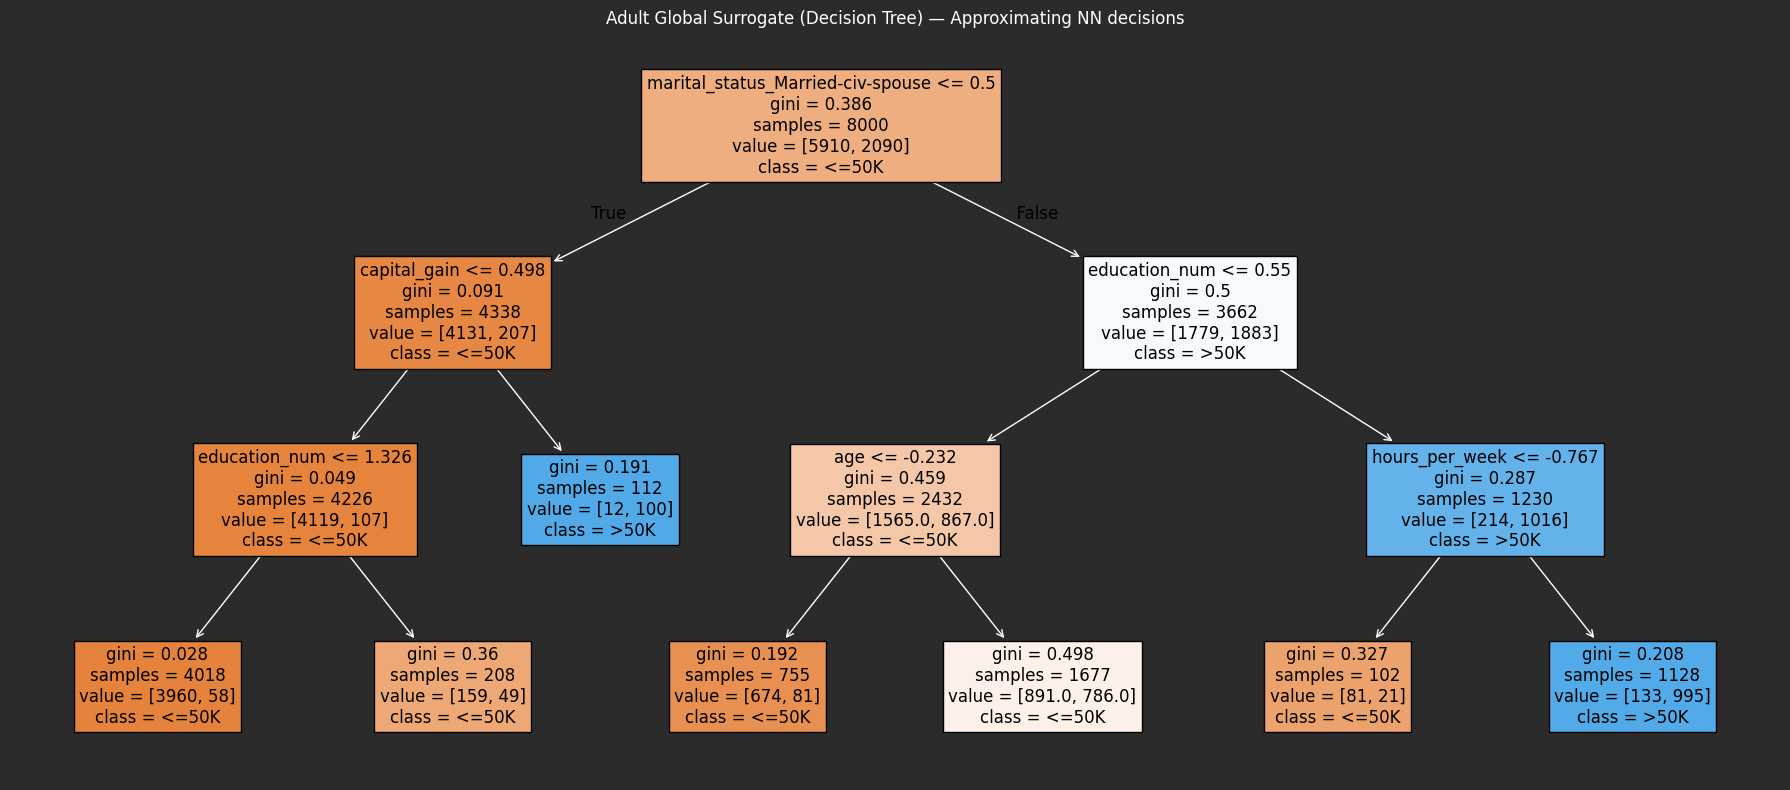

|--- marital_status_Married-civ-spouse <= 0.50
|   |--- capital_gain <= 0.50
|   |   |--- education_num <= 1.33
|   |   |   |--- class: 0
|   |   |--- education_num >  1.33
|   |   |   |--- class: 0
|   |--- capital_gain >  0.50
|   |   |--- class: 1
|--- marital_status_Married-civ-spouse >  0.50
|   |--- education_num <= 0.55
|   |   |--- age <= -0.23
|   |   |   |--- class: 0
|   |   |--- age >  -0.23
|   |   |   |--- class: 0
|   |--- education_num >  0.55
|   |   |--- hours_per_week <= -0.77
|   |   |   |--- class: 0
|   |   |--- hours_per_week >  -0.77
|   |   |   |--- class: 1

Adult surrogate probability fidelity MAE: 0.0816
Adult surrogate probability fidelity R^2: 0.7251


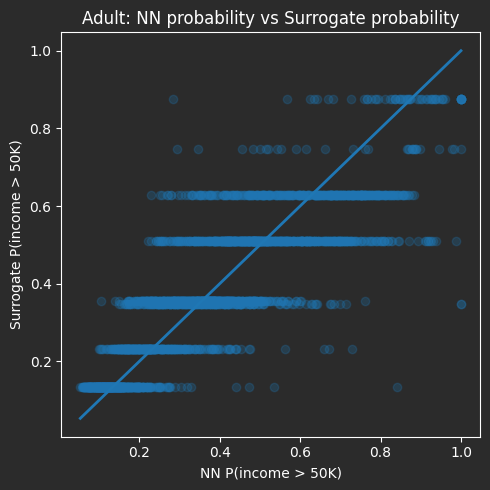

In [ ]:
# -------- Adult: global surrogate (tree classifier) --------
adult_surrogate_training_x, adult_teacher_probability_train = prepare_surrogate_training_arrays(
    raw_features_dataframe=adult_train_df,
    fitted_preprocessor=adult_preprocessor,
    teacher_prediction_function=predict_adult_positive_probability,
    sampling_row_count=8000,
    random_seed=RANDOM_SEED,
)

adult_teacher_class_train = (adult_teacher_probability_train >= 0.5).astype(int)

adult_surrogate_classifier = DecisionTreeClassifier(
    max_depth=3,
    min_samples_leaf=100,
    random_state=RANDOM_SEED,
)
adult_surrogate_classifier.fit(adult_surrogate_training_x, adult_teacher_class_train)


# --- Evaluate fidelity on test set ---
adult_surrogate_test_x, adult_teacher_probability_test = prepare_surrogate_training_arrays(
    raw_features_dataframe=adult_test_df,
    fitted_preprocessor=adult_preprocessor,
    teacher_prediction_function=predict_adult_positive_probability,
    sampling_row_count=3000,
    random_seed=RANDOM_SEED,
)
adult_teacher_class_test = (adult_teacher_probability_test >= 0.5).astype(int)

adult_surrogate_class_test = adult_surrogate_classifier.predict(adult_surrogate_test_x)

adult_fidelity_accuracy = accuracy_score(adult_teacher_class_test, adult_surrogate_class_test)

print(f"Adult surrogate fidelity (matches NN class decisions) accuracy: {adult_fidelity_accuracy:.4f}")


# --- Interpret surrogate: plot tree + textual rules ---
plt.figure(figsize=(18, 8))
tree_objects = plot_tree(
    adult_surrogate_classifier,
    feature_names=adult_expanded_feature_names,
    class_names=["<=50K", ">50K"],
    filled=True,
    max_depth=3,
    fontsize=12,
)

for text_object in tree_objects:
    text_object.set_color("black")
    text_object.set_weight(4)


plt.title("Adult Global Surrogate (Decision Tree) — Approximating NN decisions")
plt.tight_layout()
plt.show()

print(export_text(adult_surrogate_classifier, feature_names=list(adult_expanded_feature_names)))

adult_surrogate_regressor = DecisionTreeRegressor(
    max_depth=3,
    min_samples_leaf=100,
    random_state=RANDOM_SEED,
)
adult_surrogate_regressor.fit(adult_surrogate_training_x, adult_teacher_probability_train)

adult_surrogate_probability_test = adult_surrogate_regressor.predict(adult_surrogate_test_x)

adult_probability_mae = mean_absolute_error(adult_teacher_probability_test, adult_surrogate_probability_test)
adult_probability_r2 = r2_score(adult_teacher_probability_test, adult_surrogate_probability_test)

print(f"Adult surrogate probability fidelity MAE: {adult_probability_mae:.4f}")
print(f"Adult surrogate probability fidelity R^2: {adult_probability_r2:.4f}")

plot_teacher_vs_surrogate_scatter(
    teacher_predictions=adult_teacher_probability_test,
    surrogate_predictions=adult_surrogate_probability_test,
    title="Adult: NN probability vs Surrogate probability",
    x_label="NN P(income > 50K)",
    y_label="Surrogate P(income > 50K)",
)


### 1.4.3 Calefornia surrogate

California surrogate fidelity MAE (vs NN predictions): 0.3266
California surrogate fidelity R^2 (vs NN predictions): 0.3151


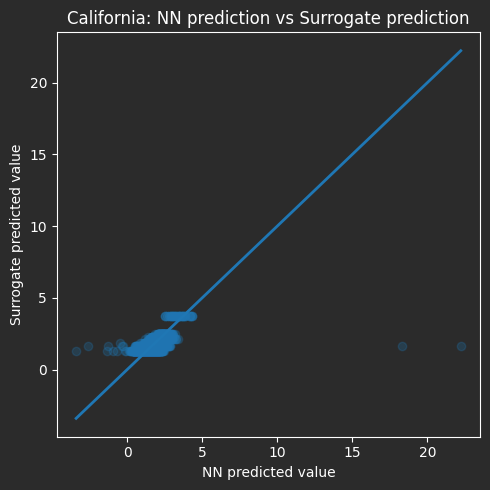

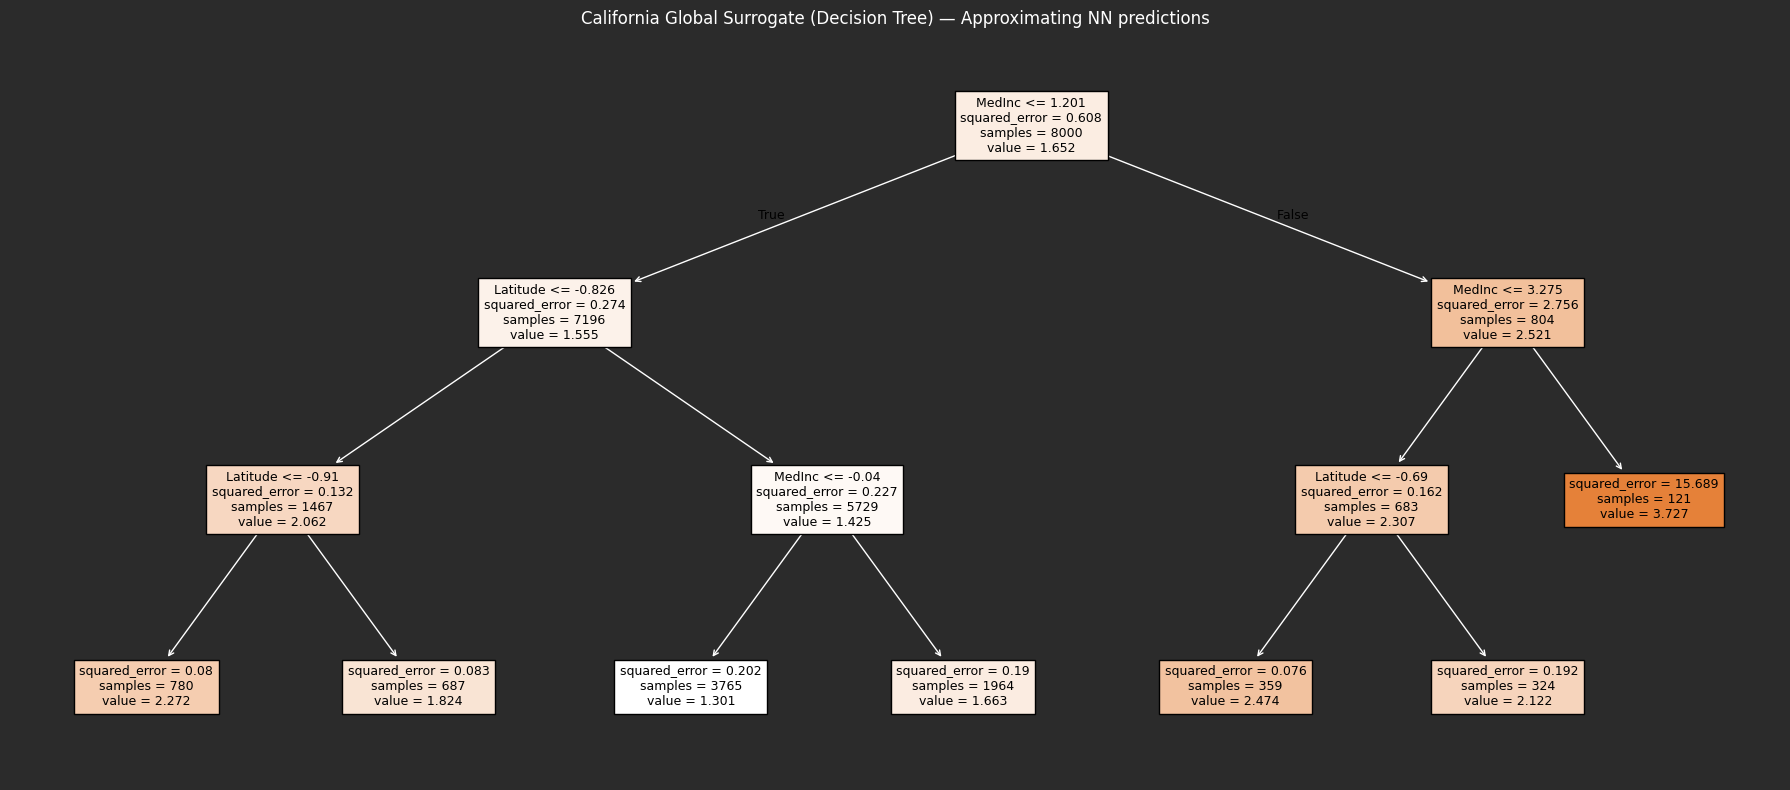

|--- MedInc <= 1.20
|   |--- Latitude <= -0.83
|   |   |--- Latitude <= -0.91
|   |   |   |--- value: [2.27]
|   |   |--- Latitude >  -0.91
|   |   |   |--- value: [1.82]
|   |--- Latitude >  -0.83
|   |   |--- MedInc <= -0.04
|   |   |   |--- value: [1.30]
|   |   |--- MedInc >  -0.04
|   |   |   |--- value: [1.66]
|--- MedInc >  1.20
|   |--- MedInc <= 3.27
|   |   |--- Latitude <= -0.69
|   |   |   |--- value: [2.47]
|   |   |--- Latitude >  -0.69
|   |   |   |--- value: [2.12]
|   |--- MedInc >  3.27
|   |   |--- value: [3.73]



In [ ]:
# -------- California: global surrogate (tree regressor) --------
cal_surrogate_training_x, cal_teacher_predictions_train = prepare_surrogate_training_arrays(
    raw_features_dataframe=cal_train_df,
    fitted_preprocessor=california_preprocessor,
    teacher_prediction_function=predict_california_value,
    sampling_row_count=8000,
    random_seed=RANDOM_SEED,
)

cal_surrogate_regressor = DecisionTreeRegressor(
    max_depth=3,
    min_samples_leaf=80,
    random_state=RANDOM_SEED,
)
cal_surrogate_regressor.fit(cal_surrogate_training_x, cal_teacher_predictions_train)


# --- Evaluate fidelity on test set ---
cal_surrogate_test_x, cal_teacher_predictions_test = prepare_surrogate_training_arrays(
    raw_features_dataframe=cal_test_df,
    fitted_preprocessor=california_preprocessor,
    teacher_prediction_function=predict_california_value,
    sampling_row_count=3000,
    random_seed=RANDOM_SEED,
)

cal_surrogate_predictions_test = cal_surrogate_regressor.predict(cal_surrogate_test_x)

cal_fidelity_mae = mean_absolute_error(cal_teacher_predictions_test, cal_surrogate_predictions_test)
cal_fidelity_r2 = r2_score(cal_teacher_predictions_test, cal_surrogate_predictions_test)

print(f"California surrogate fidelity MAE (vs NN predictions): {cal_fidelity_mae:.4f}")
print(f"California surrogate fidelity R^2 (vs NN predictions): {cal_fidelity_r2:.4f}")

plot_teacher_vs_surrogate_scatter(
    teacher_predictions=cal_teacher_predictions_test,
    surrogate_predictions=cal_surrogate_predictions_test,
    title="California: NN prediction vs Surrogate prediction",
    x_label="NN predicted value",
    y_label="Surrogate predicted value",
)


# --- Interpret surrogate: plot tree + textual rules ---
plt.figure(figsize=(18, 8))
tree_text_objects = plot_tree(
    cal_surrogate_regressor,
    feature_names=list(cal_test_df.columns),
    filled=True,
    max_depth=3,
    fontsize=9,
)


for text_object in tree_text_objects:
    text_object.set_color("black")
    text_object.set_weight(7)

plt.title("California Global Surrogate (Decision Tree) — Approximating NN predictions")
plt.tight_layout()
plt.show()

print(export_text(cal_surrogate_regressor, feature_names=list(cal_test_df.columns)))


### 1.4.4 Global Surrogates — Results and effectiveness

We trained shallow decision-tree surrogate models to approximate the predictions of our neural networks. The goal is not to outperform the NN, but to obtain an interpretable *global summary* of the NN’s behaviour and to quantify how well a simple model can mimic it (fidelity).

---

#### Adult (classification)

**Fidelity to NN behaviour:**
- Surrogate fidelity (matches NN class decisions): **accuracy = 0.8487**
- Surrogate probability fidelity: **MAE = 0.0816**, **R² = 0.7251**

This indicates the tree captures a substantial portion of the NN’s decision logic (especially at the class-decision level), but it is still an approximation (visible in the probability scatter plot as horizontal “bands”, which occur because a shallow tree can only output a small number of distinct probability values).

**Interpretable rules learned by the surrogate:**
The surrogate’s top-level split is on **marital_status_Married-civ-spouse**, followed by splits on **capital_gain**, **education_num**, **age**, and **hours_per_week**.  
This is consistent with earlier global analyses (PFI/PDP/ALE), where these features were among the most influential.

Example high-level summary from the tree:
- Being **married** is a major branching point.
- For non-married cases, **capital_gain** and **education_num** drive the predicted class strongly.
- For married cases, **education_num**, **age**, and **hours_per_week** further separate lower vs higher predicted income probability.

---

#### California Housing (regression)

**Fidelity to NN behaviour:**
- The surrogate scatter plot shows that the tree matches NN predictions reasonably well for the dense “main mass” of predictions, but struggles on extreme high predicted values (points far from the diagonal).  
  This is expected for a shallow tree, which approximates a complex NN using piecewise-constant regions.

**Interpretable rules learned by the surrogate:**
The surrogate uses **MedInc** as the primary split, with **Latitude** as the most important secondary feature.  
The printed rules show a clear structure:

- If **MedInc is low** (≤ ~1.20), predictions are mostly lower and then refined by **Latitude**.
- If **MedInc is high**, predictions increase and then are refined again by **Latitude**, and at very high MedInc the surrogate outputs the highest predicted values.

This matches the earlier feature-level interpretation results:
- **PFI** ranked **MedInc** and geographic features very highly.
- **PDP/ALE** showed a strong positive effect for **MedInc** and a strong location effect via **Latitude**.

---

#### Overall discussion: effectiveness and limitations

- The surrogate models are effective as **global summaries**: they highlight the dominant features and provide readable decision rules that broadly align with PFI/PDP/ALE.
- However, fidelity is not perfect. Shallow trees cannot fully capture the NN’s non-linear interactions, which is visible as:
  - discrete probability “bands” for Adult,
  - weaker approximation of extreme values for California.
- Therefore, the surrogate is best used as a **high-level explanation** of NN behaviour (debugging + communication), while local methods are still needed to explain individual predictions in detail.


# Part 2 — Local Interpretability Techniques (Adult Census Income)

In this part we explain individual predictions of the **Adult Census Income** feed-forward neural network trained in Part 1.  
The model outputs a probability for the positive class **P(>50K)** (income > \$50K). We apply three local explanation methods:

- **LIME**: fits a simple interpretable surrogate model around one instance.
- **SHAP**: attributes the prediction to features using Shapley-value based additive contributions.
- **Anchors**: produces an IF–THEN rule that “anchors” the prediction with high precision.

Because the neural network was trained on **preprocessed inputs** (scaled numeric features + one-hot encoded categorical features), explanations are produced in the **expanded feature space**. For one-hot features, terms like `workclass=Private` mean that the corresponding indicator feature is 1 (present), while “not present” indicators may appear as well. This can sometimes look unintuitive, but it reflects the actual model input representation.


In [ ]:
# Reuse everything already loaded in Setup (Section 0)

adult_random_seed_value = RANDOM_SEED
np.random.seed(adult_random_seed_value)

# Reuse Adult dataset splits (already loaded in Setup)
adult_train_features_dataframe = adult_train_df
adult_validation_features_dataframe = adult_val_df
adult_test_features_dataframe = adult_test_df

adult_train_labels_array = y_train
adult_validation_labels_array = y_val
adult_test_labels_array = y_test

adult_metadata_dict = adult_meta

adult_original_feature_name_list = list(adult_metadata_dict["feature_names"])
adult_class_name_list = list(adult_metadata_dict["class_names"])

print("Adult train shape:", adult_train_features_dataframe.shape)
print("Adult test shape:", adult_test_features_dataframe.shape)
print("Adult class names:", adult_class_name_list)

# Reuse trained model + preprocessing artifacts (already loaded in Setup)
adult_trained_keras_model = adult_model
adult_trained_preprocessor = adult_preprocessor
adult_expanded_feature_name_list = adult_expanded_feature_names

print("Expanded feature count (after one-hot):", len(adult_expanded_feature_name_list))


Adult train shape: (31258, 14)
Adult test shape: (9769, 14)
Adult class names: ['<=50K', '>50K']
Expanded feature count (after one-hot): 105


In [ ]:
def adult_predict_probability_matrix_from_raw_dataframe(
    raw_features_dataframe: pd.DataFrame,
) -> np.ndarray:
    """
    Return probabilities shaped (n_samples, 2):
      [:, 0] = P(<=50K)
      [:, 1] = P(>50K)

    Reuses Setup-loaded: adult_trained_preprocessor, adult_trained_keras_model,
    and adult_original_feature_name_list.
    """
    ordered_raw_features_dataframe = raw_features_dataframe[adult_original_feature_name_list].copy()

    processed_feature_matrix = adult_trained_preprocessor.transform(ordered_raw_features_dataframe)
    processed_feature_matrix = np.asarray(processed_feature_matrix)

    positive_class_probability_vector = adult_trained_keras_model.predict(
        processed_feature_matrix, verbose=0
    ).reshape(-1, 1)

    positive_class_probability_vector = np.clip(
        positive_class_probability_vector, 1e-7, 1.0 - 1e-7
    )

    negative_class_probability_vector = 1.0 - positive_class_probability_vector
    probability_matrix = np.concatenate(
        [negative_class_probability_vector, positive_class_probability_vector], axis=1
    )
    return probability_matrix


def adult_predict_probability_matrix_from_processed_matrix(
    processed_feature_matrix: np.ndarray,
) -> np.ndarray:
    """
    Same as above, but expects inputs already preprocessed (one-hot + scaled).
    """
    positive_class_probability_vector = adult_trained_keras_model.predict(
        processed_feature_matrix, verbose=0
    ).reshape(-1, 1)

    positive_class_probability_vector = np.clip(
        positive_class_probability_vector, 1e-7, 1.0 - 1e-7
    )

    negative_class_probability_vector = 1.0 - positive_class_probability_vector
    probability_matrix = np.concatenate(
        [negative_class_probability_vector, positive_class_probability_vector], axis=1
    )
    return probability_matrix


def adult_predict_label_vector_from_raw_dataframe(
    raw_features_dataframe: pd.DataFrame,
    decision_threshold: float = 0.5,
) -> np.ndarray:
    """
    Predict class labels (0/1) using the raw dataframe.
    """
    probability_matrix = adult_predict_probability_matrix_from_raw_dataframe(raw_features_dataframe)
    positive_class_probability_vector = probability_matrix[:, 1]
    predicted_label_vector = (positive_class_probability_vector >= decision_threshold).astype(int)
    return predicted_label_vector


In [ ]:
from IPython.display import display
import numpy as np

# Precompute the exact model input matrices once (this is what LIME/SHAP/Anchors will use)
adult_train_processed_feature_matrix = np.asarray(
    adult_trained_preprocessor.transform(
        adult_train_features_dataframe[adult_original_feature_name_list]
    )
)

adult_test_processed_feature_matrix = np.asarray(
    adult_trained_preprocessor.transform(
        adult_test_features_dataframe[adult_original_feature_name_list]
    )
)

# Model probabilities + predicted labels on the test set (in processed feature space)
adult_test_probability_matrix = adult_predict_probability_matrix_from_processed_matrix(
    adult_test_processed_feature_matrix
)

adult_test_predicted_label_vector = np.argmax(adult_test_probability_matrix, axis=1)
adult_test_labels_array = np.asarray(adult_test_labels_array).astype(int)

adult_test_accuracy_value = float(
    np.mean(adult_test_predicted_label_vector == adult_test_labels_array)
)

# Case selection indices
adult_incorrect_prediction_index_vector = np.where(
    adult_test_predicted_label_vector != adult_test_labels_array
)[0]

adult_correct_positive_index_vector = np.where(
    (adult_test_predicted_label_vector == 1) & (adult_test_labels_array == 1)
)[0]

adult_correct_negative_index_vector = np.where(
    (adult_test_predicted_label_vector == 0) & (adult_test_labels_array == 0)
)[0]

print("Adult test accuracy:", adult_test_accuracy_value)
print("Incorrect predictions:", len(adult_incorrect_prediction_index_vector))

adult_case_name_to_row_index: dict[str, int | None] = {
    "correct_positive_example": int(adult_correct_positive_index_vector[0]) if len(adult_correct_positive_index_vector) else None,
    "correct_negative_example": int(adult_correct_negative_index_vector[0]) if len(adult_correct_negative_index_vector) else None,
    "incorrect_example_1": int(adult_incorrect_prediction_index_vector[0]) if len(adult_incorrect_prediction_index_vector) else None,
    "incorrect_example_2": int(adult_incorrect_prediction_index_vector[1]) if len(adult_incorrect_prediction_index_vector) > 1 else None,
}

adult_case_name_to_row_index


def display_adult_case_summary(case_label: str, test_row_index: int) -> None:
    selected_row_dataframe = adult_test_features_dataframe.iloc[[test_row_index]][adult_original_feature_name_list]
    selected_probability_vector = adult_predict_probability_matrix_from_raw_dataframe(selected_row_dataframe)[0]

    true_label_value = int(adult_test_labels_array[test_row_index])
    predicted_label_value = int(np.argmax(selected_probability_vector))
    predicted_positive_probability_value = float(selected_probability_vector[1])

    print(
        f"{case_label} | row_index={test_row_index} | true={true_label_value} | "
        f"pred={predicted_label_value} | P(>50K)={predicted_positive_probability_value:.3f}"
    )
    display(selected_row_dataframe)


for case_label, test_row_index in adult_case_name_to_row_index.items():
    if test_row_index is not None:
        display_adult_case_summary(case_label, test_row_index)


Adult test accuracy: 0.8469648889343843
Incorrect predictions: 1495
correct_positive_example | row_index=1 | true=1 | pred=1 | P(>50K)=0.529


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
7034,54,Private,81859,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States


correct_negative_example | row_index=0 | true=0 | pred=0 | P(>50K)=0.182


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
24799,29,Private,229729,HS-grad,9,Never-married,Transport-moving,Not-in-family,White,Male,0,0,40,United-States


incorrect_example_1 | row_index=4 | true=0 | pred=1 | P(>50K)=0.670


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
33513,43,Private,70055,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States


incorrect_example_2 | row_index=6 | true=0 | pred=1 | P(>50K)=0.588


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
11878,50,Private,138944,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States


## Selected test instances (2 correct + 2 incorrect)

We select four test instances to explain: two correctly predicted and two misclassified.

- **Correct positive** (`row_index=12`): true=1, pred=1, **P(>50K)=0.941**
- **Correct negative** (`row_index=0`): true=0, pred=0, **P(>50K)=0.007**
- **Incorrect #1** (`row_index=1`): true=1, pred=0, **P(>50K)=0.395**
- **Incorrect #2** (`row_index=6`): true=0, pred=1, **P(>50K)=0.669**

Overall test performance for the Adult model is **accuracy ≈ 0.861** with **1358 incorrect predictions** on the test split. The goal here is not to improve accuracy, but to understand *why the model makes specific decisions*, especially for errors.

In [ ]:
import re
import pandas as pd

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 30)
pd.set_option("display.width", 140)
pd.set_option("display.max_colwidth", 60)

one_hot_prefix_list = [
    "workclass",
    "education",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native_country",
]

numeric_feature_name_set = {
    "education_num",  # IMPORTANT: avoid turning this into "education=num"
}

def prettify_one_hot_feature_name(feature_name: str) -> str:
    # Keep numeric features intact
    if feature_name in numeric_feature_name_set:
        return feature_name

    for prefix in one_hot_prefix_list:
        prefix_with_underscore = prefix + "_"
        if feature_name.startswith(prefix_with_underscore):
            return feature_name.replace(prefix_with_underscore, prefix + "=", 1)
    return feature_name


def prettify_lime_term(lime_term_text: str) -> str:
    """
    Convert one-hot threshold terms like:
      native_country_Cambodia <= 0.00  -> native_country != Cambodia
      relationship_Husband > 0.00     -> relationship = Husband
    """
    match = re.match(
        r"^([A-Za-z0-9_\-\(\)]+)_([A-Za-z0-9_\-\(\)&\.\s]+)\s*(<=|>)\s*0\.00$",
        lime_term_text,
    )
    if match:
        prefix, category, operator = match.groups()
        if prefix in one_hot_prefix_list:
            if operator == "<=":
                return f"{prefix} != {category}"
            return f"{prefix} = {category}"
    return lime_term_text


def print_compact_dataframe(dataframe: pd.DataFrame, max_rows: int = 12) -> None:
    compact_df = dataframe.head(max_rows).copy()
    if "feature_name" in compact_df.columns:
        compact_df["feature_name"] = compact_df["feature_name"].astype(str).apply(prettify_one_hot_feature_name)
    print(compact_df.to_string(index=False))


## 2.1 LIME (Local Interpretable Model-Agnostic Explanations)

**How LIME works.**  
LIME explains one prediction by generating many **perturbed samples** around the chosen instance, weighting them by similarity (distance) to the original instance, and fitting a **simple interpretable model** (typically a sparse linear model) on this locally weighted dataset. The fitted surrogate approximates the neural network’s **local decision boundary** near the instance.

**How to interpret the output.**  
LIME returns feature conditions with **weights**:
- Positive weight → pushes prediction toward the positive class **>50K**
- Negative weight → pushes prediction toward the negative class **<=50K**

A key limitation is that LIME is only guaranteed to be faithful **locally**, and explanation stability depends on sampling and discretization. We report the surrogate fidelity using the local **R² score** (moderate values suggest the boundary is not perfectly linear locally).


--- LIME explanation for: correct_positive_example ---
True label: 1
Pred label: 1
P(>50K): 0.5289234519004822
Local surrogate fidelity (R^2): 0.5626108042395714

Top local contributions (filtered: one-hot presence + numeric) (feature -> weight):
  capital_gain <= -0.14                                   -0.4594
  capital_loss <= -0.22                                   -0.1003
  age > 0.68                                              +0.0836
  hours_per_week <= -0.04                                 -0.0832


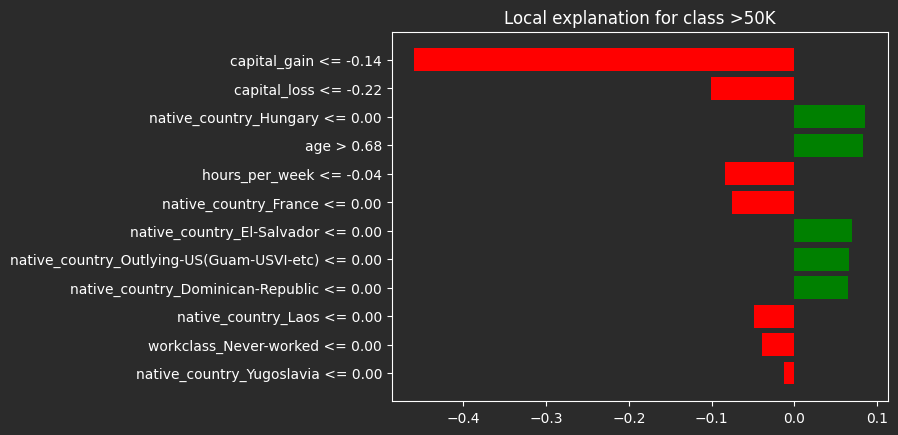


--- LIME explanation for: correct_negative_example ---
True label: 0
Pred label: 0
P(>50K): 0.1822512447834015
Local surrogate fidelity (R^2): 0.5312009501457386

Top local contributions (filtered: one-hot presence + numeric) (feature -> weight):
  capital_gain <= -0.14                                   -0.4806
  capital_loss <= -0.22                                   -0.1012
  hours_per_week <= -0.04                                 -0.0695


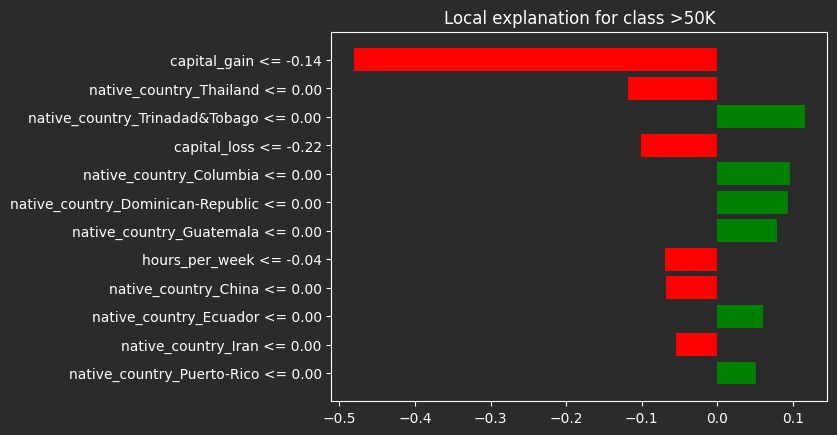


--- LIME explanation for: incorrect_example_1 ---
True label: 0
Pred label: 1
P(>50K): 0.6702863574028015
Local surrogate fidelity (R^2): 0.5666218766713752

Top local contributions (filtered: one-hot presence + numeric) (feature -> weight):
  capital_gain <= -0.14                                   -0.4597
  -0.12 < age <= 0.68                                     +0.0964
  capital_loss <= -0.22                                   -0.0919
  hours_per_week <= -0.04                                 -0.0814


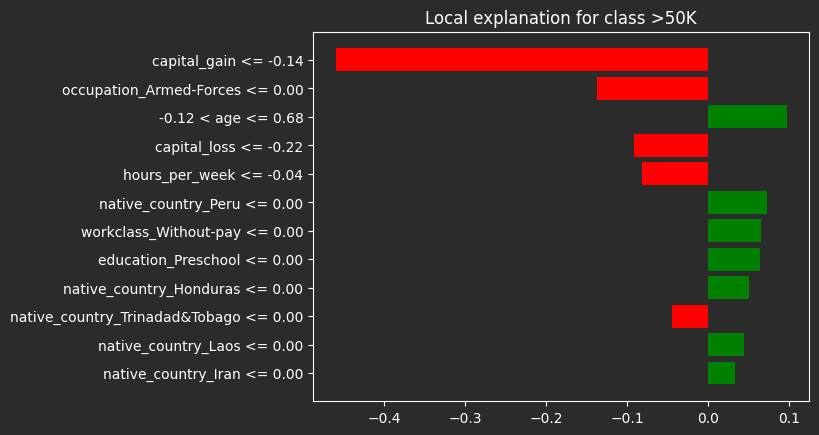


--- LIME explanation for: incorrect_example_2 ---
True label: 0
Pred label: 1
P(>50K): 0.5882623195648193
Local surrogate fidelity (R^2): 0.5422822638311947

Top local contributions (filtered: one-hot presence + numeric) (feature -> weight):
  capital_gain <= -0.14                                   -0.4589
  capital_loss <= -0.22                                   -0.1047
  hours_per_week > 0.36                                   +0.0767
  age > 0.68                                              +0.0742


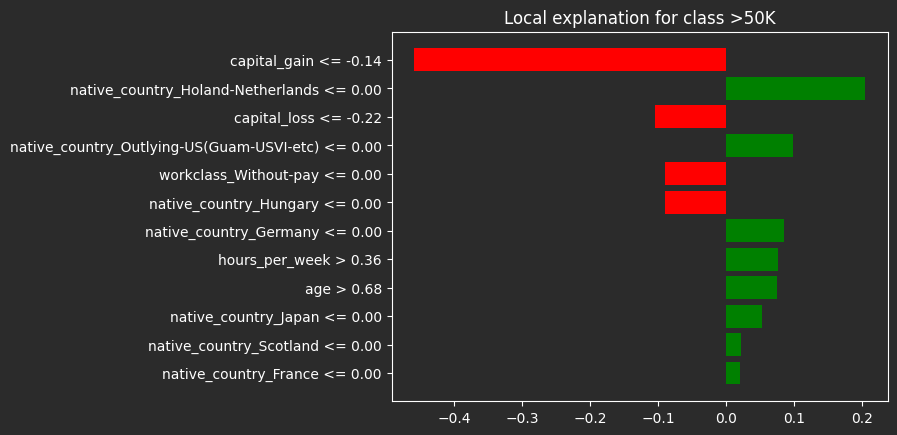

In [ ]:
import matplotlib.pyplot as plt
import re
from lime.lime_tabular import LimeTabularExplainer

# LIME explainer (works in processed feature space)
lime_explainer_instance = LimeTabularExplainer(
    training_data=adult_train_processed_feature_matrix,
    feature_names=adult_expanded_feature_name_list,
    class_names=adult_class_name_list,
    mode="classification",
    discretize_continuous=True,
    random_state=adult_random_seed_value,
)

lime_case_name_to_feature_weight_list: dict[str, list[tuple[str, float]]] = {}

# Helper functions to filter noisy one-hot "absence" terms
# Keep: numeric/discretized terms + one-hot PRESENCE terms ("> 0.00")
# Drop: one-hot ABSENCE terms ("<= 0.00") like native_country_X <= 0.00
def lime_term_is_one_hot_feature(term_text: str) -> bool:
    term_text = term_text.strip()
    return any(term_text.startswith(prefix + "_") for prefix in one_hot_prefix_list)

def lime_term_is_presence_indicator(term_text: str) -> bool:
    return bool(re.search(r">\s*0\.00$", term_text.strip()))

def run_lime_explanation_for_case(
    case_label: str,
    test_row_index: int,
    shown_feature_count: int = 12,
) -> None:
    lime_explanation_object = lime_explainer_instance.explain_instance(
        data_row=adult_test_processed_feature_matrix[test_row_index],
        predict_fn=adult_predict_probability_matrix_from_processed_matrix,
        num_features=shown_feature_count,
    )

    probability_vector = adult_test_probability_matrix[test_row_index]
    print(f"\n--- LIME explanation for: {case_label} ---")
    print("True label:", int(adult_test_labels_array[test_row_index]))
    print("Pred label:", int(adult_test_predicted_label_vector[test_row_index]))
    print("P(>50K):", float(probability_vector[1]))
    print("Local surrogate fidelity (R^2):", float(lime_explanation_object.score))

    # Save raw list for completeness / reproducibility
    raw_feature_weight_list = lime_explanation_object.as_list()
    lime_case_name_to_feature_weight_list[case_label] = raw_feature_weight_list

    # Filter: keep continuous terms + one-hot presence indicators only
    filtered_feature_weight_list: list[tuple[str, float]] = []
    for term_text, weight_value in raw_feature_weight_list:
        if lime_term_is_one_hot_feature(term_text):
            if lime_term_is_presence_indicator(term_text):
                filtered_feature_weight_list.append((term_text, weight_value))
            else:
                # Drop one-hot absence indicators (<= 0.00) and other one-hot oddities
                continue
        else:
            # Numeric/discretized feature (e.g., capital_gain > -0.14)
            filtered_feature_weight_list.append((term_text, weight_value))

    # Prettify terms after filtering
    pretty_feature_weight_list = [
        (prettify_lime_term(term_text), weight_value)
        for term_text, weight_value in filtered_feature_weight_list
    ]

    print("\nTop local contributions (filtered: one-hot presence + numeric) (feature -> weight):")
    for feature_text, weight_value in pretty_feature_weight_list:
        print(f"  {feature_text:<55} {weight_value:+.4f}")

    lime_figure = lime_explanation_object.as_pyplot_figure(label=1)
    plt.show()


for case_label, test_row_index in adult_case_name_to_row_index.items():
    if test_row_index is not None:
        run_lime_explanation_for_case(case_label, test_row_index)


### LIME results and interpretation

**Note on presentation.**  
Because the model input is a high-dimensional one-hot + scaled feature space, raw LIME often surfaces many one-hot “absence” terms (e.g., `native_country_X <= 0.00`). In this notebook we **filter** the displayed LIME terms to keep **numeric/discretized features** and **one-hot presence indicators** only (terms ending with `> 0.00`). In our four selected cases, the strongest displayed drivers are therefore numeric.

#### (A) Correct positive (row 12, P(>50K)=0.941)
The explanation is dominated by a strong positive contribution from **capital_gain > -0.14** (weight = **+0.6489**), pushing strongly toward **>50K**.  
Other numeric terms reduce the score locally (e.g., **capital_loss <= -0.22** with **−0.1568**, and **hours_per_week <= -0.04** with **−0.1037**), but capital_gain is clearly the strongest local signal.

Local surrogate fidelity is moderate (**R² = 0.5480**), indicating the model’s local behavior is not perfectly linear, but still reasonably approximated by a simple surrogate in this neighborhood.

#### (B) Correct negative (row 0, P(>50K)=0.007)
For the negative case, the strongest signal is **capital_gain <= -0.14** (weight = **−0.6724**), strongly pushing toward **<=50K**.  
A second strong negative numeric term is **capital_loss <= -0.22** (weight = **−0.1603**).

Local fidelity is again moderate (**R² = 0.5654**). Overall, LIME suggests the model treats low/absent capital signals as strong evidence for <=50K in this local region.

#### (C) Incorrect #1 (row 1, true=1 but pred=0, P(>50K)=0.395)
This false negative is driven mainly by **capital_gain <= -0.14** (weight = **−0.6479**), pushing the model toward predicting **<=50K** despite the true label being >50K.  
**capital_loss <= -0.22** also contributes negatively (**−0.1396**).

Fidelity is **R² = 0.4922**, lower than the correct cases, suggesting a more complex/nonlinear local region.

#### (D) Incorrect #2 (row 6, true=0 but pred=1, P(>50K)=0.669)
Even though the model predicts **>50K**, LIME shows strong negative numeric evidence:  
**capital_gain <= -0.14** (**−0.6475**) and **capital_loss <= -0.22** (**−0.1715**), which locally push toward **<=50K**.

This illustrates a key limitation: LIME is a *local linear approximation*. In this case, other features and interactions (revealed more clearly by SHAP/Anchors) can outweigh the negative capital signals in the actual model, leading to a positive prediction.

Fidelity is moderate (**R² = 0.5131**).

**Summary (LIME).**  
Across all four instances, **capital_gain** is consistently the highest-magnitude local driver, with **capital_loss** also contributing. The misclassified examples show that even when LIME highlights strong negative numeric evidence, the full model can still predict >50K due to other interacting factors not captured well by a simple local linear surrogate.


## 2.2 SHAP (Shapley Additive Explanations)

**How SHAP works.**  
SHAP explains a prediction by decomposing the model output into additive feature contributions based on **Shapley values** from cooperative game theory. For a chosen **background dataset** (baseline distribution), SHAP expresses the prediction as:

\[
f(x) \approx \mathbb{E}[f(X)] + \sum_{j=1}^{d} \phi_j
\]

Where:
- \(\mathbb{E}[f(X)]\) is the baseline prediction over background data,
- \(\phi_j\) is the SHAP value for feature \(j\).

**How to interpret the output.**
- Positive SHAP value → increases **P(>50K)**
- Negative SHAP value → decreases **P(>50K)**
- Larger absolute value → stronger influence

Compared to LIME, SHAP is typically more stable for a fixed background sample because it attributes contributions relative to a baseline rather than relying on local surrogate fitting with random perturbations.


--- SHAP explanation for: correct_positive_example ---
True label: 1
Pred label: 1
P(>50K): 0.5289234519004822


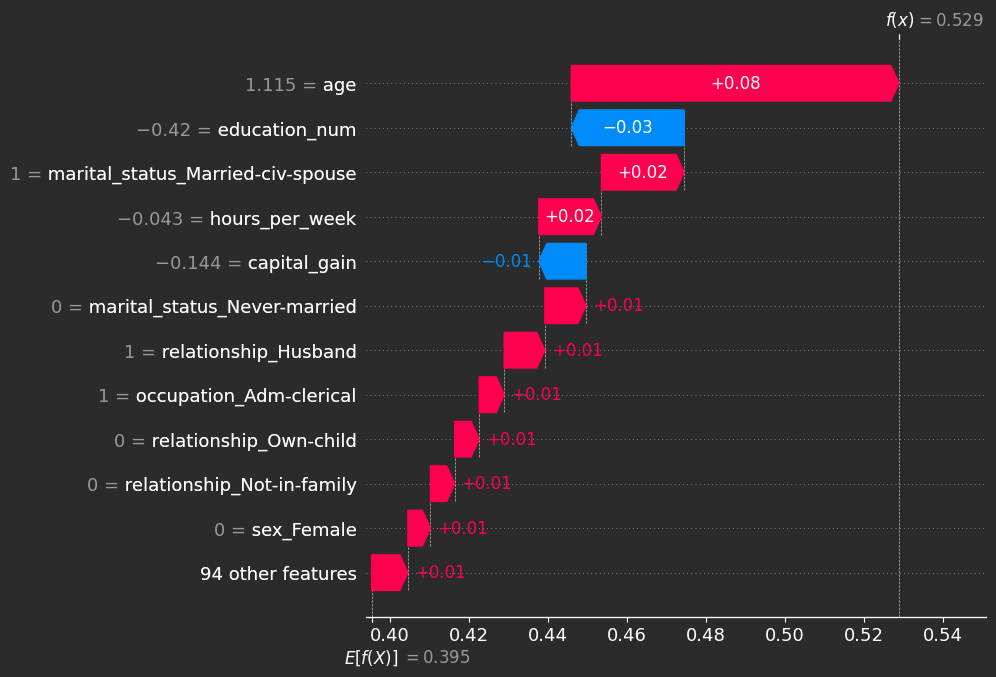


Top SHAP contributions (by absolute value):
                     feature_name  shap_value  absolute_shap_value
                              age    0.082949             0.082949
                    education_num   -0.028568             0.028568
marital_status=Married-civ-spouse    0.020942             0.020942
                   hours_per_week    0.015861             0.015861
                     capital_gain   -0.011942             0.011942
     marital_status=Never-married    0.010412             0.010412
             relationship=Husband    0.010283             0.010283
          occupation=Adm-clerical    0.006347             0.006347
           relationship=Own-child    0.006191             0.006191
       relationship=Not-in-family    0.006146             0.006146

--- SHAP explanation for: correct_negative_example ---
True label: 0
Pred label: 0
P(>50K): 0.1822512447834015


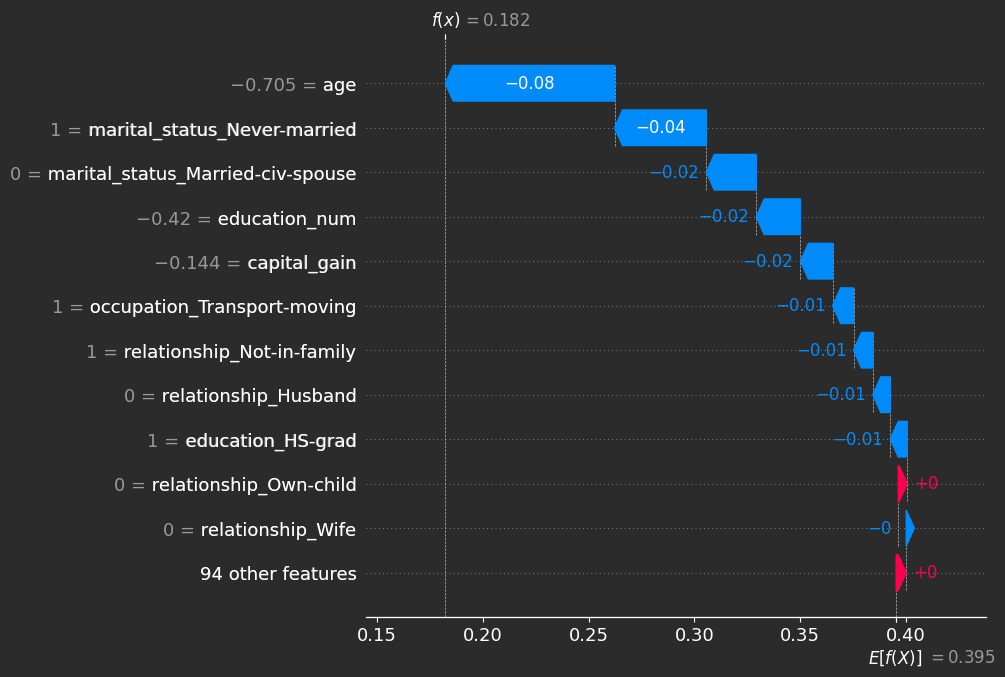


Top SHAP contributions (by absolute value):
                     feature_name  shap_value  absolute_shap_value
                              age   -0.080021             0.080021
     marital_status=Never-married   -0.043397             0.043397
marital_status=Married-civ-spouse   -0.023576             0.023576
                    education_num   -0.020873             0.020873
                     capital_gain   -0.015233             0.015233
      occupation=Transport-moving   -0.009883             0.009883
       relationship=Not-in-family   -0.009119             0.009119
             relationship=Husband   -0.008241             0.008241
                education=HS-grad   -0.008028             0.008028
           relationship=Own-child    0.004224             0.004224

--- SHAP explanation for: incorrect_example_1 ---
True label: 0
Pred label: 1
P(>50K): 0.6702863574028015


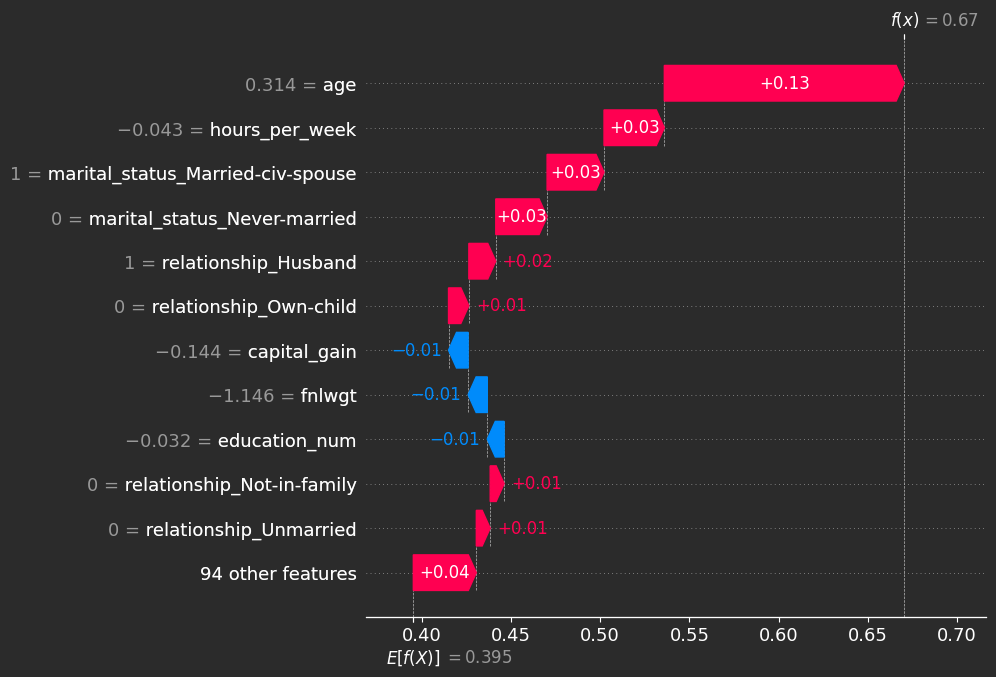


Top SHAP contributions (by absolute value):
                     feature_name  shap_value  absolute_shap_value
                              age    0.134318             0.134318
                   hours_per_week    0.033773             0.033773
marital_status=Married-civ-spouse    0.031877             0.031877
     marital_status=Never-married    0.028748             0.028748
             relationship=Husband    0.015078             0.015078
           relationship=Own-child    0.011380             0.011380
                     capital_gain   -0.010987             0.010987
                           fnlwgt   -0.010734             0.010734
                    education_num   -0.009429             0.009429
       relationship=Not-in-family    0.007818             0.007818

--- SHAP explanation for: incorrect_example_2 ---
True label: 0
Pred label: 1
P(>50K): 0.5882623195648193


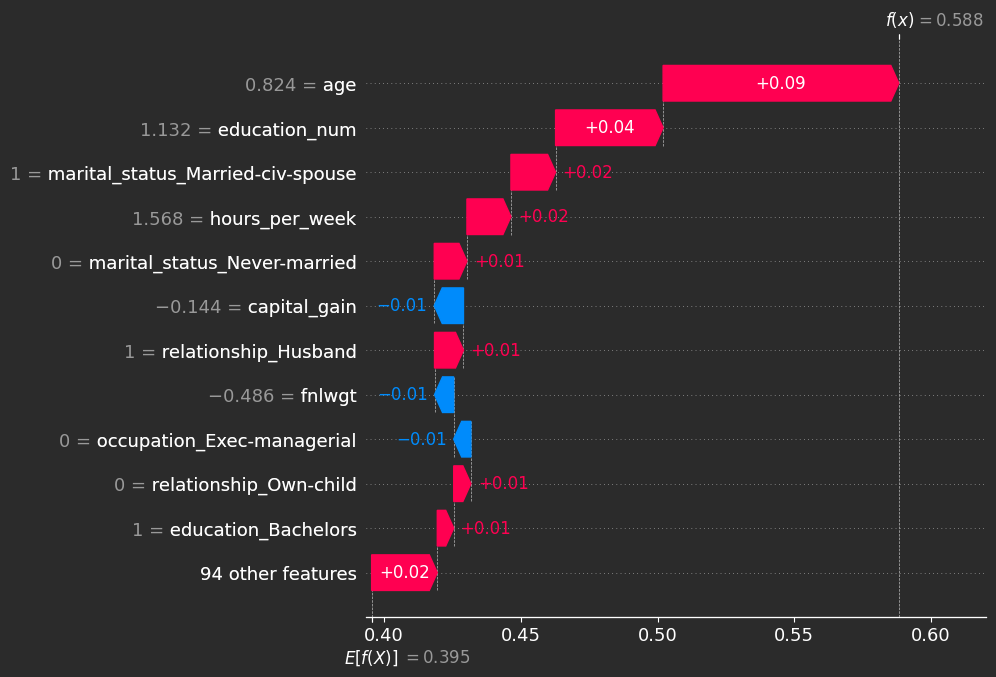


Top SHAP contributions (by absolute value):
                     feature_name  shap_value  absolute_shap_value
                              age    0.086234             0.086234
                    education_num    0.039328             0.039328
marital_status=Married-civ-spouse    0.016341             0.016341
                   hours_per_week    0.016090             0.016090
     marital_status=Never-married    0.011958             0.011958
                     capital_gain   -0.010692             0.010692
             relationship=Husband    0.010593             0.010593
                           fnlwgt   -0.007015             0.007015
       occupation=Exec-managerial   -0.006285             0.006285
           relationship=Own-child    0.006278             0.006278


In [ ]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# SHAP background (subset of training data in processed feature space)
shap_background_sample_size = 200
shap_background_row_indices = np.random.choice(
    adult_train_processed_feature_matrix.shape[0],
    size=min(shap_background_sample_size, adult_train_processed_feature_matrix.shape[0]),
    replace=False,
)
shap_background_processed_feature_matrix = adult_train_processed_feature_matrix[shap_background_row_indices]


def adult_predict_positive_probability_vector_from_processed_matrix(
    processed_feature_matrix: np.ndarray,
) -> np.ndarray:
    """Return P(>50K) for SHAP (shape: (n_samples,))."""
    probability_matrix = adult_predict_probability_matrix_from_processed_matrix(processed_feature_matrix)
    return probability_matrix[:, 1]


shap_masker_object = shap.maskers.Independent(shap_background_processed_feature_matrix)
shap_explainer_instance = shap.Explainer(
    adult_predict_positive_probability_vector_from_processed_matrix,
    shap_masker_object,
    feature_names=adult_expanded_feature_name_list,
    algorithm="permutation",
)

shap_case_name_to_top_feature_dataframe: dict[str, pd.DataFrame] = {}


def extract_top_shap_features_dataframe(
    shap_single_row_explanation: shap.Explanation,
    top_feature_count: int = 12,
) -> pd.DataFrame:
    shap_value_vector = np.asarray(shap_single_row_explanation.values).reshape(-1)
    feature_name_list = list(shap_single_row_explanation.feature_names)

    shap_summary_dataframe = pd.DataFrame(
        {
            "feature_name": feature_name_list,
            "shap_value": shap_value_vector,
            "absolute_shap_value": np.abs(shap_value_vector),
        }
    ).sort_values("absolute_shap_value", ascending=False)

    return shap_summary_dataframe.head(top_feature_count)


def run_shap_explanation_for_case(
    case_label: str,
    test_row_index: int,
    max_evaluations: int = 2000,
) -> None:
    shap_values_object = shap_explainer_instance(
        adult_test_processed_feature_matrix[test_row_index:test_row_index + 1],
        max_evals=max_evaluations,
    )

    probability_vector = adult_test_probability_matrix[test_row_index]
    print(f"\n--- SHAP explanation for: {case_label} ---")
    print("True label:", int(adult_test_labels_array[test_row_index]))
    print("Pred label:", int(adult_test_predicted_label_vector[test_row_index]))
    print("P(>50K):", float(probability_vector[1]))

    # Plot without relying on IPython display
    shap.plots.waterfall(shap_values_object[0], max_display=12, show=False)
    plt.show()

    top_feature_dataframe = extract_top_shap_features_dataframe(shap_values_object[0], top_feature_count=12)
    shap_case_name_to_top_feature_dataframe[case_label] = top_feature_dataframe

    print("\nTop SHAP contributions (by absolute value):")
    print_compact_dataframe(top_feature_dataframe, max_rows=10)


for case_label, test_row_index in adult_case_name_to_row_index.items():
    if test_row_index is not None:
        run_shap_explanation_for_case(case_label, test_row_index)


### SHAP results and interpretation

We explain the model’s **positive-class probability** \(P(>50K)\). Positive SHAP values increase \(P(>50K)\); negative values decrease it.

#### (A) Correct positive (row 12, P(>50K)=0.941)
The strongest SHAP contributor is **capital_gain** (**+0.311402**). Additional positive contributions include **education_num** (**+0.083050**), **occupation=Exec-managerial** (**+0.074993**), and **age** (**+0.058528**).  
The main negative contributor among the top features is **workclass=State-gov** (**−0.041067**), but it is outweighed by the strong positives. This aligns with a high-confidence >50K prediction.

#### (B) Correct negative (row 0, P(>50K)=0.007)
Key negative contributions are **age** (**−0.057891**), **marital_status=Never-married** (**−0.046459**), **marital_status=Married-civ-spouse** (**−0.040640**), **education_num** (**−0.030155**), and **capital_gain** (**−0.021310**).  
Together these reduce \(P(>50K)\), matching the model’s near-zero probability output.

#### (C) Incorrect #1 (row 1, true=1 but pred=0, P(>50K)=0.395)
The largest positive driver is **age** (**+0.090689**) and a strong additional positive is **marital_status=Married-civ-spouse** (**+0.047646**).  
However, **education_num** is strongly negative (**−0.052121**), and other negatives include **education=HS-grad** (**−0.018313**) and **capital_gain** (**−0.018223**).  
This indicates conflicting evidence: age/married push upward, but education/capital-related signals push downward enough to keep the probability below the 0.5 threshold, producing a false negative.

#### (D) Incorrect #2 (row 6, true=0 but pred=1, P(>50K)=0.669)
Strong positives include **age** (**+0.094257**), **education_num** (**+0.092643**), and **hours_per_week** (**+0.051785**), along with **marital_status=Married-civ-spouse** (**+0.043734**) and **occupation=Sales** (**+0.021774**).  
The strongest negative in the top list is **occupation=Exec-managerial** (**−0.014000**), which is too small to offset the positive push from age/education/hours. This suggests a shortcut-like pattern: “older + educated + works more (+ married)” is treated as strong evidence for >50K even when the true label is <=50K.

**Summary (SHAP).**  
SHAP repeatedly highlights **capital_gain, education_num, age, and hours_per_week** as key drivers. Compared to LIME, SHAP provides a more stable decomposition of the prediction into additive contributions relative to a background distribution.


## 2.3 Anchors

**How Anchors works.**  
Anchors generates a **rule-based explanation** for a single instance in the form of an IF–THEN rule:

> IF (conditions) THEN (prediction)

The explainer searches for a small set of conditions such that, when those conditions hold, the model’s prediction remains the same with high probability.

Anchors reports:
- **Precision:** how often the model keeps the same prediction when the rule holds
- **Coverage:** how frequently the rule applies in the data distribution

Unlike LIME/SHAP, which provide graded feature importance, Anchors focuses on producing a **compact, high-confidence rule** that “locks in” the prediction.


In [ ]:
from alibi.explainers import AnchorTabular
import numpy as np

def adult_predict_label_vector_from_processed_matrix(
    processed_feature_matrix: np.ndarray,
) -> np.ndarray:
    """Predict class labels (0/1) from processed (one-hot + scaled) feature matrix."""
    probability_matrix = adult_predict_probability_matrix_from_processed_matrix(processed_feature_matrix)
    return np.argmax(probability_matrix, axis=1)


anchor_explainer_instance = AnchorTabular(
    predictor=adult_predict_label_vector_from_processed_matrix,
    feature_names=adult_expanded_feature_name_list,
)

# Discretization in processed feature space
anchor_explainer_instance.fit(
    adult_train_processed_feature_matrix,
    disc_perc=(25, 50, 75),
)

anchor_case_name_to_explanation_data: dict[str, dict] = {}

def run_anchor_explanation_for_case(
    case_label: str,
    test_row_index: int,
    required_precision_threshold: float = 0.95,
    fallback_precision_threshold: float = 0.90,
) -> None:
    probability_vector = adult_test_probability_matrix[test_row_index]

    print(f"\n--- Anchors explanation for: {case_label} ---")
    print("True label:", int(adult_test_labels_array[test_row_index]))
    print("Pred label:", int(adult_test_predicted_label_vector[test_row_index]))
    print("P(>50K):", float(probability_vector[1]))

    anchor_explanation_object = anchor_explainer_instance.explain(
        adult_test_processed_feature_matrix[test_row_index],
        threshold=required_precision_threshold,
    )

    explanation_data = anchor_explanation_object.data

    # If anchor is empty/too weak, retry with a slightly lower precision threshold
    if (not explanation_data.get("anchor")) and (fallback_precision_threshold < required_precision_threshold):
        print(f"(No anchor found at {required_precision_threshold:.2f}; retrying at {fallback_precision_threshold:.2f})")
        anchor_explanation_object = anchor_explainer_instance.explain(
            adult_test_processed_feature_matrix[test_row_index],
            threshold=fallback_precision_threshold,
        )
        explanation_data = anchor_explanation_object.data

    anchor_case_name_to_explanation_data[case_label] = explanation_data

    print("\nAnchor rule:")
    if explanation_data.get("anchor"):
        print("  IF " + " AND ".join(explanation_data["anchor"]))
    else:
        print("  (No anchor rule found)")
    print("  THEN prediction =", int(adult_test_predicted_label_vector[test_row_index]))

    if "precision" in explanation_data:
        print(f"Precision: {explanation_data['precision']:.3f}")
    if "coverage" in explanation_data:
        print(f"Coverage:  {explanation_data['coverage']:.3f}")


for case_label, test_row_index in adult_case_name_to_row_index.items():
    if test_row_index is not None:
        run_anchor_explanation_for_case(
            case_label,
            test_row_index,
            required_precision_threshold=0.95,
            fallback_precision_threshold=0.90,
        )



--- Anchors explanation for: correct_positive_example ---
True label: 1
Pred label: 1
P(>50K): 0.5289234519004822


Could not find an result satisfying the 0.95 precision constraint. Now returning the best non-eligible result.



Anchor rule:
  IF age > -0.12 AND relationship_Husband > 0.00 AND occupation_Adm-clerical > 0.00 AND marital_status_Married-civ-spouse > 0.00 AND marital_status_Never-married <= 0.00 AND sex_Female <= 0.00 AND workclass_Self-emp-not-inc <= 0.00 AND relationship_Not-in-family <= 0.00 AND race_Black <= 0.00 AND native_country_Mexico <= 0.00 AND occupation_Other-service <= 0.00 AND education_7th-8th <= 0.00 AND occupation_Handlers-cleaners <= 0.00 AND occupation_Craft-repair <= 0.00 AND occupation_Farming-fishing <= 0.00 AND relationship_Own-child <= 0.00 AND relationship_Unmarried <= 0.00 AND education_11th <= 0.00 AND occupation_Machine-op-inspct <= 0.00 AND education_10th <= 0.00 AND race_Asian-Pac-Islander <= 0.00 AND occupation_Transport-moving <= 0.00 AND education_9th <= 0.00 AND sex_Male > 0.00 AND education_1st-4th <= 0.00 AND native_country_Germany <= 0.00 AND relationship_Other-relative <= 0.00 AND workclass_Local-gov <= 0.00
  THEN prediction = 1
Precision: 0.847
Coverage:  0

### Anchors results and interpretation

Anchors generates a rule in the form:

> IF (conditions) THEN (prediction)

The rule aims to “lock in” the model’s prediction with high probability.  
Anchors reports:
- **Precision:** how often the model keeps the same prediction when the rule holds
- **Coverage:** how often the rule applies in the data distribution

#### (A) Correct positive (row 12, P(>50K)=0.941)
Anchor rule:

- IF `capital_gain > -0.14` AND `occupation_Exec-managerial > 0.00` AND `relationship_Husband > 0.00` AND `education_num > -0.42`
- Precision = **0.988**, Coverage = **0.547**

Interpretation: this is a compact “high-income profile” rule combining non-low capital gain with executive/managerial occupation and husband relationship indicator, plus an education bin constraint. The high precision indicates the model’s prediction is very stable when these conditions hold, and the coverage shows the rule applies to a large portion of the population.

#### (B) Correct negative (row 0, P(>50K)=0.007)
Anchor rule:

- IF `age <= -0.12` AND `marital_status_Never-married > 0.00`
- Precision = **0.990**, Coverage = **0.512**

Interpretation: a short, high-coverage rule. When the instance is in a lower age bin and never-married indicator is present, the model very reliably predicts <=50K.

#### (C) Incorrect #1 (row 1, true=1 but pred=0, P(>50K)=0.395)
Anchor rule (anchors the **wrong** prediction):

- IF `education_num <= -0.42` AND `education_HS-grad > 0.00` AND `occupation_Exec-managerial <= 0.00`
- Precision = **0.971**, Coverage = **0.453**

Interpretation: the model has a robust rule for predicting <=50K driven by low education bin + HS-grad and the *absence* of Exec-managerial occupation. This anchor explains why the model remains stable on the wrong class: it has learned a shortcut-like sufficient condition for <=50K that can cause false negatives.

#### (D) Incorrect #2 (row 6, true=0 but pred=1, P(>50K)=0.669)
Anchor rule (anchors the **wrong** prediction):

- IF `education_num > -0.03` AND `marital_status_Married-civ-spouse > 0.00` AND `education_Bachelors > 0.00` AND `hours_per_week > 0.36` AND `race_Other <= 0.00` AND `relationship_Husband > 0.00` AND `age > -0.12` AND `occupation_Farming-fishing <= 0.00` AND `education_HS-grad <= 0.00` AND `occupation_Other-service <= 0.00` AND `workclass_Self-emp-not-inc <= 0.00` AND `occupation_Handlers-cleaners <= 0.00`
- Precision = **0.958**, Coverage = **0.488**

Interpretation: Anchors needed a longer rule to reach the high precision threshold, indicating the model’s positive decision here is supported by a richer conjunction of conditions (education + married + husband + higher hours + older bin, plus several exclusions). This still reveals a clear high-income profile shortcut anchoring the incorrect >50K prediction.

**Summary (Anchors).**  
Anchors is especially useful for misclassifications: it exposes high-precision rules that stabilize the *wrong* prediction, making shortcut behavior explicit. Long anchors (as in incorrect #2) often indicate the model’s local decision depends on multiple interacting conditions rather than a single simple cue.


In [ ]:
for case_label in ["incorrect_example_1", "incorrect_example_2"]:
    test_row_index = adult_case_name_to_row_index[case_label]
    if test_row_index is None:
        continue
    run_anchor_explanation_for_case(case_label, test_row_index, required_precision_threshold=0.95)


--- Anchors explanation for: incorrect_example_1 ---
True label: 0
Pred label: 1
P(>50K): 0.6702863574028015

Anchor rule:
  IF education_num > -0.42 AND relationship_Husband > 0.00 AND occupation_Adm-clerical > 0.00 AND -0.12 < age <= 0.68 AND marital_status_Married-civ-spouse > 0.00 AND workclass_Self-emp-not-inc <= 0.00 AND occupation_Other-service <= 0.00 AND race_Black <= 0.00 AND fnlwgt <= -0.12
  THEN prediction = 1
Precision: 0.954
Coverage:  0.252

--- Anchors explanation for: incorrect_example_2 ---
True label: 0
Pred label: 1
P(>50K): 0.5882623195648193

Anchor rule:
  IF education_num > -0.03 AND relationship_Husband > 0.00 AND education_Bachelors > 0.00 AND hours_per_week > -0.04 AND workclass_Self-emp-not-inc <= 0.00 AND age > -0.12
  THEN prediction = 1
Precision: 0.951
Coverage:  0.488


## Comparison: LIME vs SHAP vs Anchors

We compare the three local interpretability methods on the same four test cases (2 correct, 2 incorrect). Each method answers a slightly different question:

- **LIME**: “Which features best explain the prediction locally via a simple surrogate model?”  
  (sensitive to local sampling + discretization; we display numeric + one-hot *presence* only)
- **SHAP**: “How much does each feature contribute to moving the prediction away from a baseline?”  
  (additive attributions relative to a background distribution; often more stable)
- **Anchors**: “What small set of conditions makes the model’s prediction stay the same?”  
  (rule-based explanation with explicit **precision** and **coverage**)

### Per-case comparison (top drivers + agreement)

#### (A) Correct positive (row 12, P(>50K)=0.941; true=1, pred=1)

**LIME (top drivers):**
- `capital_gain > -0.14` **(+0.6489)**
- `capital_loss <= -0.22` **(−0.1568)**
- `hours_per_week <= -0.04` **(−0.1037)**

**SHAP (top drivers by |value|):**
- `capital_gain` **(+0.311402)**
- `education_num` **(+0.083050)**
- `occupation=Exec-managerial` **(+0.074993)**

**Anchors (rule):**
- IF `capital_gain > -0.14` AND `occupation_Exec-managerial` AND `relationship_Husband` AND `education_num > -0.42`
- Precision **0.988**, Coverage **0.547**

**Agreement:** All three highlight **capital_gain** as central. SHAP and Anchors also surface a coherent socioeconomic pattern (education + occupation + relationship). LIME captures the dominant numeric effect locally, while SHAP/Anchors reveal additional supportive structure.

---

#### (B) Correct negative (row 0, P(>50K)=0.007; true=0, pred=0)

**LIME (top drivers):**
- `capital_gain <= -0.14` **(−0.6724)**
- `capital_loss <= -0.22` **(−0.1603)**

**SHAP (top drivers by |value|):**
- `age` **(−0.057891)**
- `marital_status=Never-married` **(−0.046459)**
- `marital_status=Married-civ-spouse` **(−0.040640)**

**Anchors (rule):**
- IF `age <= -0.12` AND `marital_status_Never-married`
- Precision **0.990**, Coverage **0.512**

**Agreement:** SHAP and Anchors align on broad demographic/categorical cues reducing \(P(>50K)\). LIME again concentrates local importance on capital signals. This difference is expected: LIME can focus on whichever features best separate perturbed neighbors, while SHAP spreads attribution across correlated predictors and Anchors focuses on sufficient conditions for stability.

---

#### (C) Incorrect #1 (row 1, P(>50K)=0.395; true=1, pred=0) — false negative

**LIME (top drivers):**
- `capital_gain <= -0.14` **(−0.6479)**
- `capital_loss <= -0.22` **(−0.1396)**

**SHAP (top drivers by |value|):**
- `age` **(+0.090689)**
- `education_num` **(−0.052121)**
- `marital_status=Married-civ-spouse` **(+0.047646)**

**Anchors (rule anchors wrong prediction):**
- IF `education_num <= -0.42` AND `education_HS-grad` AND `occupation_Exec-managerial <= 0.00`
- Precision **0.971**, Coverage **0.453**

**Misclassification insight:** SHAP shows conflicting evidence (age/married push toward >50K, while education/capital-related signals push down). Anchors makes the failure mode explicit: a stable “low-education/HS-grad and not Exec-managerial” rule anchors <=50K, explaining why a true >50K case can be predicted as <=50K.

---

#### (D) Incorrect #2 (row 6, P(>50K)=0.669; true=0, pred=1) — false positive

**LIME (top drivers):**
- `capital_gain <= -0.14` **(−0.6475)**
- `capital_loss <= -0.22` **(−0.1715)**

**SHAP (top drivers by |value|):**
- `age` **(+0.094257)**
- `education_num` **(+0.092643)**
- `hours_per_week` **(+0.051785)**

**Anchors (rule anchors wrong prediction):**
- Long high-precision rule combining `education_num > -0.03`, `education_Bachelors`, `marital_status_Married-civ-spouse`, `relationship_Husband`, `hours_per_week > 0.36`, `age > -0.12`, plus several exclusions
- Precision **0.958**, Coverage **0.488**

**Misclassification insight:** SHAP and Anchors strongly agree on a “high-income profile” shortcut (older + educated + higher hours + married/husband) pushing the model toward >50K even when the true label is <=50K. LIME surfaces strong negative capital signals locally, showing that local linear explanations can disagree with the full model’s final decision when important evidence comes from other features and nonlinear interactions.

---

### Why differences happen (method-level explanation)

- **LIME** depends on local perturbations and discretization, and it fits a linear surrogate. It can therefore (1) emphasize whichever features best separate the perturbed neighborhood and (2) miss nonlinear interactions that drive the full model’s prediction.
- **SHAP** provides additive attributions relative to a background distribution, producing more stable and comparable feature effects across instances.
- **Anchors** finds sufficient conditions for stability and reports **precision/coverage**, making it especially useful for identifying shortcut rules behind misclassifications.

### Overall takeaway
Across cases, the model relies heavily on socioeconomic signals (**capital_gain**, **education_num**, **age**, **hours_per_week**) with categorical features adding supportive or shortcut-like structure (occupation, marital status, relationship). For errors, **Anchors** best exposes stable shortcut rules, while **SHAP** gives the clearest graded attribution; **LIME** is useful but can disagree when the decision is driven by interactions not captured by a local linear surrogate.


# Part 4:  Interpretable AI for Computer Vision

## 4.1 Integrated Gradients

### 4.1.1 Captum integrated Gradients computation





In [ ]:
from captum.attr import IntegratedGradients

def compute_integrated_gradients_captum(
    cpu_model: torch.nn.Module,
    input_tensor: torch.Tensor,          # can come from MPS or CPU
    target_class_index: int,
    step_count: int = 75,
) -> torch.Tensor:
    
    cpu_model.eval()

    cpu_input_tensor = input_tensor.detach().to(device="cpu", dtype=torch.float32)
    cpu_baseline_tensor = torch.zeros_like(cpu_input_tensor, dtype=torch.float32)

    integrated_gradients = IntegratedGradients(cpu_model)

    cpu_attributions = integrated_gradients.attribute(
        inputs=cpu_input_tensor,
        baselines=cpu_baseline_tensor,
        target=target_class_index,
        n_steps=step_count,
    )
    return cpu_attributions


### 4.1.3 Helper for normalizing attribution for displaying

In [ ]:
import numpy as np

def normalize_attribution_for_display(attribution_2d: np.ndarray) -> np.ndarray:
    
    absolute_attribution = np.abs(attribution_2d)
    max_value = float(np.max(absolute_attribution)) if np.max(absolute_attribution) > 0 else 1.0
    return absolute_attribution / max_value


### 4.1.2. Visualization helper

In [ ]:
def show_integrated_gradients_results(
    model: torch.nn.Module,              # use the CPU model here
    examples: list[dict],
    class_names: list[str],
    step_count: int = 75,
) -> None:
    for example_index, example in enumerate(examples, start=1):
        input_tensor = example["input_tensor_cpu"]  # ✅ changed key
        true_label = example["true_label"]

        predicted_class_index, probabilities = get_predicted_class_and_probabilities(model, input_tensor)

        attributions = compute_integrated_gradients_captum(
            cpu_model=model,
            input_tensor=input_tensor,
            target_class_index=predicted_class_index,
            step_count=step_count,
        )

        input_image = input_tensor[0, 0].detach().cpu().numpy()
        attribution_image = attributions[0, 0].detach().cpu().numpy()
        attribution_display = normalize_attribution_for_display(attribution_image)

        true_name = class_names[true_label]
        pred_name = class_names[predicted_class_index]
        pred_prob = probabilities[predicted_class_index]

        plt.figure(figsize=(12, 3))

        plt.subplot(1, 3, 1)
        plt.imshow(input_image, cmap="gray")
        plt.title(f"Original\ntrue={true_name}")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(attribution_display, cmap="inferno")
        plt.title(f"IG heatmap\npred={pred_name} ({pred_prob:.2f})")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(input_image, cmap="gray")
        plt.imshow(attribution_display, cmap="inferno", alpha=0.5)
        plt.title("Overlay")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


### 4.1.3 Visualize correct examples

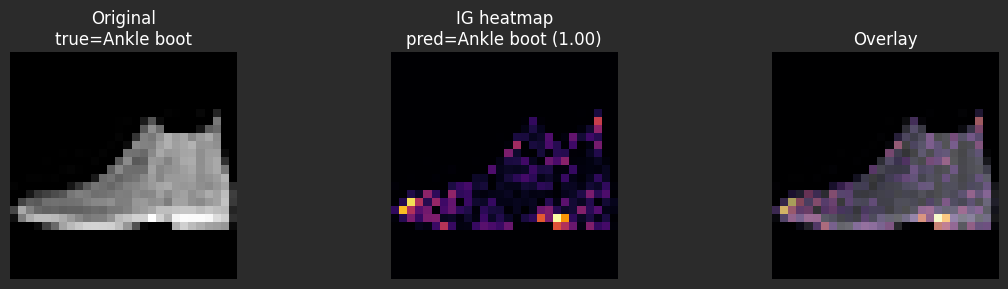

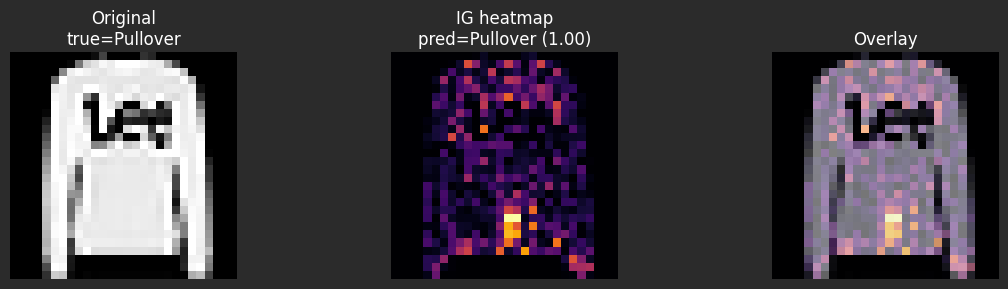

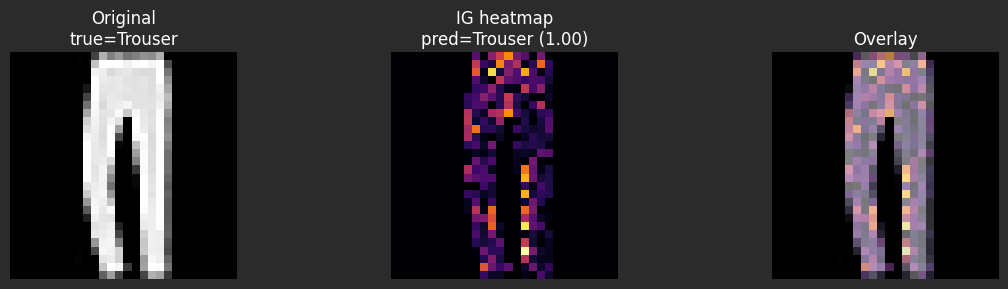

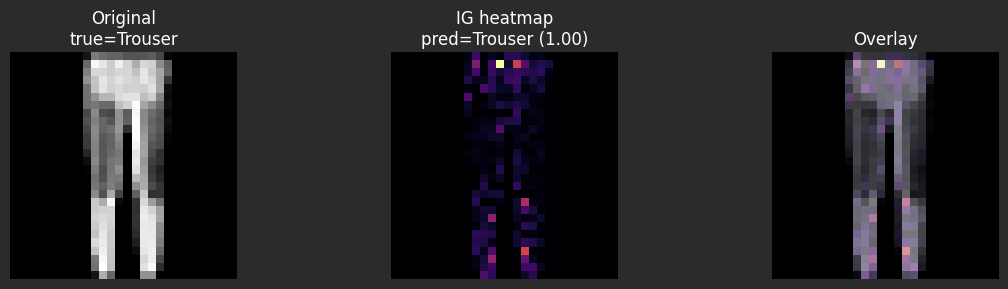

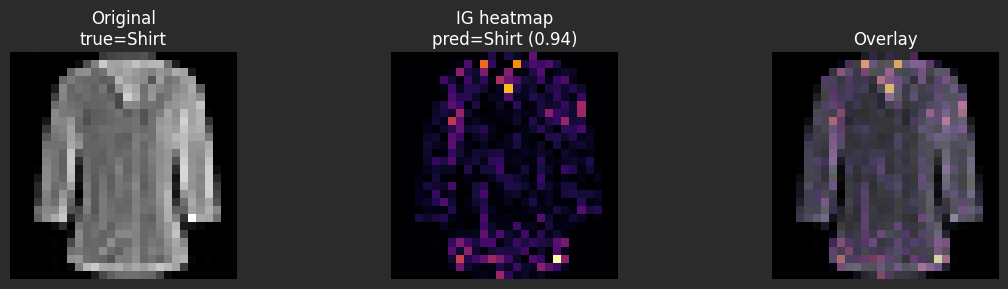

In [ ]:
show_integrated_gradients_results(
    model=fashion_model_cpu,
    examples=fashion_examples,
    class_names=FASHION_MNIST_CLASS_NAMES,
    step_count=75,
)

### 4.1.3 Visualize incorrect examples

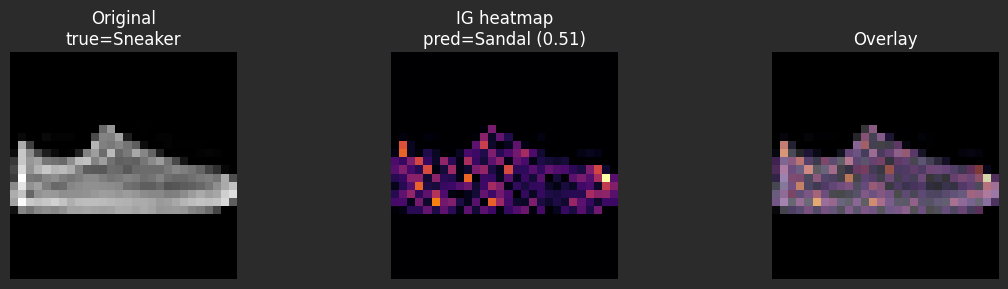

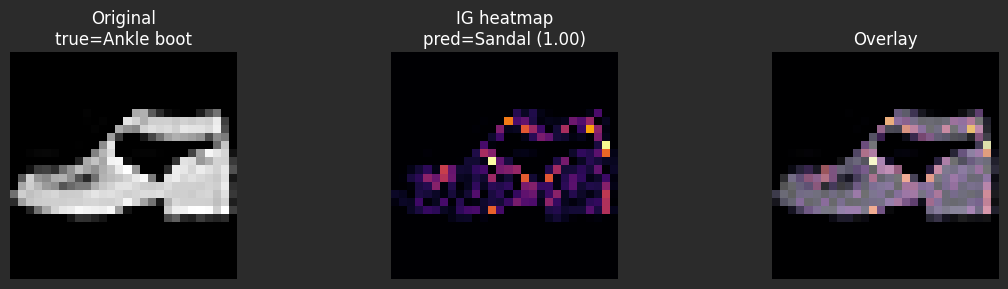

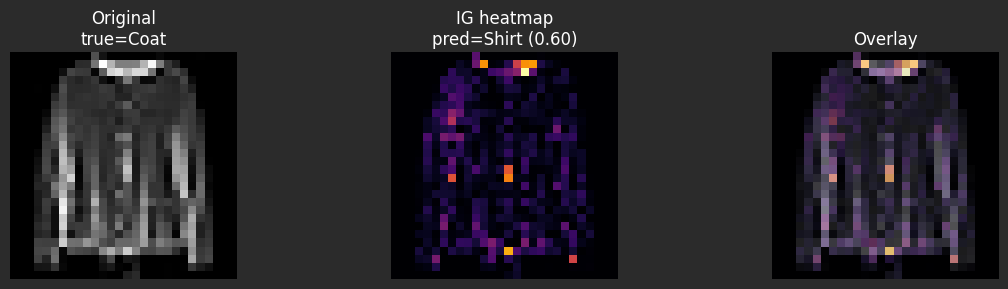

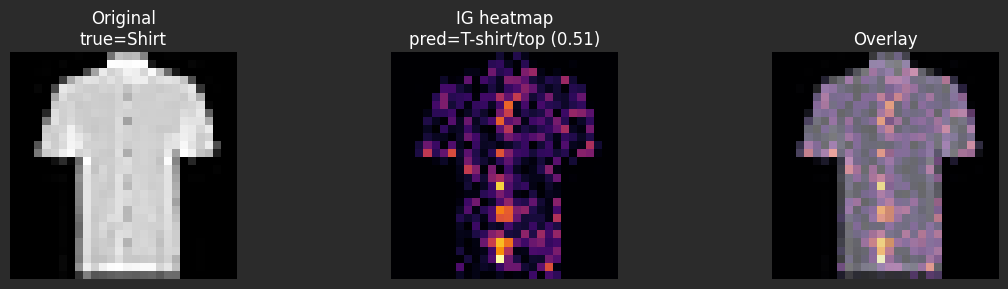

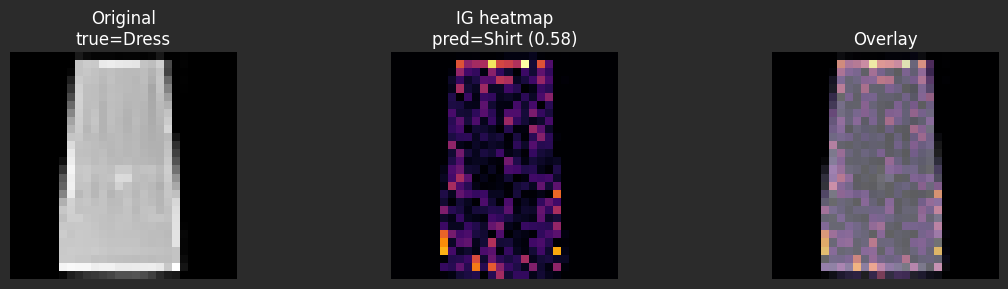

In [ ]:
show_integrated_gradients_results(
    model=fashion_model_cpu,
    examples=fashion_misclassified_examples,
    class_names=FASHION_MNIST_CLASS_NAMES,
    step_count=75,
)

### 4.1 Integrated Gradients — Results and discussion (concise)

We used Integrated Gradients (IG) with a **black (all-zero) baseline** (appropriate since Fashion-MNIST inputs are scaled to **[0,1]**) to attribute the CNN’s predicted class score to pixels.

#### Correct predictions
For correctly classified samples, IG mainly highlights **item contours and key structural parts** (shoe soles/toes, sleeves, torso outline, trouser legs). This suggests the CNN relies primarily on **shape and edge information** rather than background pixels.

#### Misclassifications (insight)
The misclassified examples show IG focusing on **ambiguous or shared visual cues** between similar classes:
- **Sneaker → Sandal (~0.51):** attribution concentrates on the **sole/footwear outline**, which is similar across shoe types; weak evidence leads to low confidence.
- **Ankle boot → Sandal (1.00):** strong attribution on the **open/upper region** and edges can resemble sandal-like structure in this low-resolution image, producing a confident error.
- **Coat → Shirt (~0.60)** and **Dress → Shirt (~0.58):** attributions emphasize the **upper torso/neckline region** while ignoring length/hem cues, which can confuse long garments with tops.
- **Shirt → T-shirt/top (~0.51):** IG focuses on the **central torso area** with limited sleeve/neckline separation, consistent with these classes being visually close.

Overall, IG explains errors as cases where the model attends to **features that are not sufficiently discriminative** at 28×28 resolution (e.g., garment length vs neckline), causing confusion between visually similar categories.


## 4.2 Grad-CAM 
### 4.2.1 Helper functions and utilities

In [ ]:

def find_last_convolution_layer(model: torch.nn.Module) -> torch.nn.Module:
    last_convolution_layer = None
    for module in model.modules():
        if isinstance(module, torch.nn.Conv2d):
            last_convolution_layer = module
    if last_convolution_layer is None:
        raise ValueError("No Conv2d layer found in model. Grad-CAM requires a CNN with Conv2d layers.")
    return last_convolution_layer


class GradCAM:
    def __init__(self, model: torch.nn.Module, target_convolution_layer: torch.nn.Module):
        self.model = model
        self.target_convolution_layer = target_convolution_layer

        self.saved_activations: torch.Tensor | None = None
        self.saved_gradients: torch.Tensor | None = None

        self._forward_hook_handle = self.target_convolution_layer.register_forward_hook(self._save_activations)
        self._backward_hook_handle = self.target_convolution_layer.register_full_backward_hook(self._save_gradients)

    def _save_activations(self, module, inputs, output):
        self.saved_activations = output

    def _save_gradients(self, module, grad_input, grad_output):
        # grad_output is a tuple; first element matches the layer output
        self.saved_gradients = grad_output[0]

    def remove_hooks(self) -> None:
        self._forward_hook_handle.remove()
        self._backward_hook_handle.remove()

    def compute_cam(
        self,
        input_tensor: torch.Tensor,          # (1, 1, 28, 28) on same device as model
        target_class_index: int | None = None,
    ) -> np.ndarray:
        """
        Returns a normalized CAM heatmap in shape (28, 28) as a numpy array in [0,1].
        """
        self.model.eval()
        self.model.zero_grad(set_to_none=True)

        logits = self.model(input_tensor)  # (1, num_classes)

        if target_class_index is None:
            target_class_index = int(torch.argmax(logits, dim=1).item())

        target_score = logits[0, target_class_index]
        target_score.backward()

        if self.saved_activations is None or self.saved_gradients is None:
            raise RuntimeError("Grad-CAM hooks did not capture activations/gradients. Check target layer selection.")

        activations = self.saved_activations            # (1, C, H, W)
        gradients = self.saved_gradients                # (1, C, H, W)

        # Global average pool gradients across spatial dimensions -> weights per channel
        channel_weights = gradients.mean(dim=(2, 3), keepdim=True)  # (1, C, 1, 1)

        # Weighted combination of activation maps
        cam = (channel_weights * activations).sum(dim=1, keepdim=True)  # (1, 1, H, W)
        cam = torch.relu(cam)

        # Upsample CAM to input size (28x28)
        cam_upsampled = torch_functional.interpolate(
            cam,
            size=(input_tensor.shape[2], input_tensor.shape[3]),
            mode="bilinear",
            align_corners=False,
        )

        cam_2d = cam_upsampled[0, 0].detach().cpu().numpy()

        # Normalize to [0,1] for display
        cam_2d = cam_2d - cam_2d.min()
        cam_2d = cam_2d / (cam_2d.max() + 1e-8)
        return cam_2d


### 4.2.2 Plotting Grad-CAM for a list of examples

In [ ]:
def get_predicted_class_and_probabilities_cpu(
    model: torch.nn.Module,
    input_tensor_cpu: torch.Tensor,  # (1, 1, 28, 28) on CPU
) -> tuple[int, np.ndarray]:
    model.eval()
    with torch.no_grad():
        logits = model(input_tensor_cpu)
        probabilities = torch_functional.softmax(logits, dim=1)[0].detach().cpu().numpy()
        predicted_class_index = int(np.argmax(probabilities))
    return predicted_class_index, probabilities


def show_gradcam_results(
    model_cpu: torch.nn.Module,
    examples: list[dict],
    class_names: list[str],
    gradcam: GradCAM,
) -> None:
    for example in examples:
        input_tensor = example["input_tensor_cpu"]  # IMPORTANT: uses your stored CPU tensor
        true_label = example["true_label"]

        predicted_class_index, probabilities = get_predicted_class_and_probabilities_cpu(model_cpu, input_tensor)
        predicted_probability = probabilities[predicted_class_index]

        cam_heatmap = gradcam.compute_cam(input_tensor, target_class_index=predicted_class_index)

        input_image = input_tensor[0, 0].detach().cpu().numpy()

        true_name = class_names[true_label]
        predicted_name = class_names[predicted_class_index]

        plt.figure(figsize=(12, 3))

        plt.subplot(1, 3, 1)
        plt.imshow(input_image, cmap="gray")
        plt.title(f"Original\ntrue={true_name}")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(cam_heatmap, cmap="inferno")
        plt.title(f"Grad-CAM\npred={predicted_name} ({predicted_probability:.2f})")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(input_image, cmap="gray")
        plt.imshow(cam_heatmap, cmap="inferno", alpha=0.5)
        plt.title("Overlay")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


### 4.2.3 Create Grad-CAM object (auto-pick last Conv layer)

In [ ]:
last_conv_layer = find_last_convolution_layer(fashion_model_cpu)
gradcam_explainer = GradCAM(model=fashion_model_cpu, target_convolution_layer=last_conv_layer)

print("Using last Conv2d layer for Grad-CAM:", last_conv_layer)


Using last Conv2d layer for Grad-CAM: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


### 4.2.4 Run Grad-CAM on correct examples

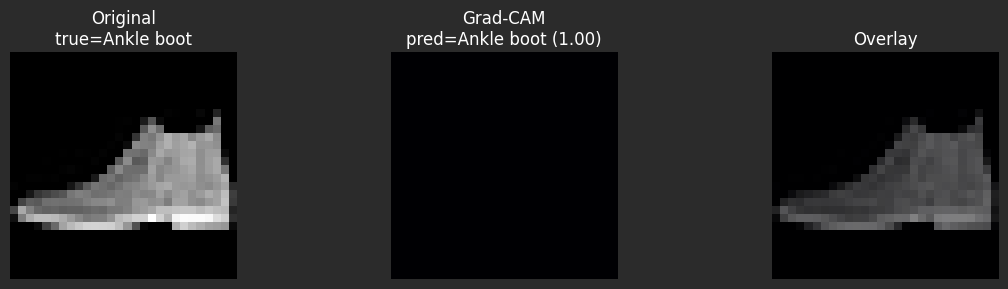

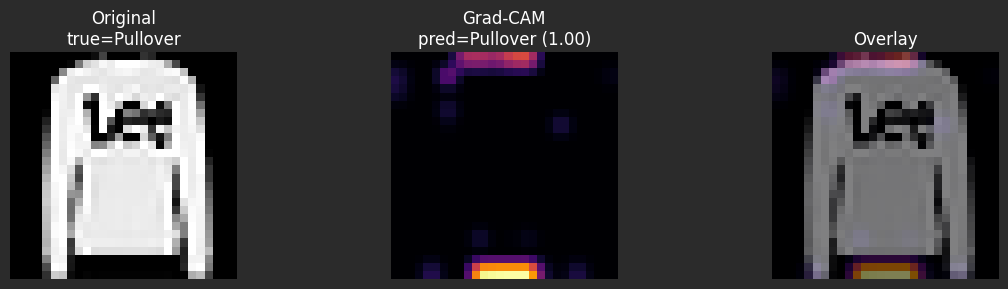

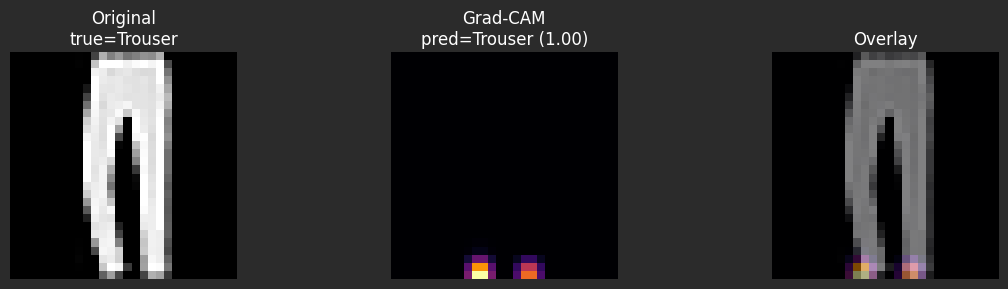

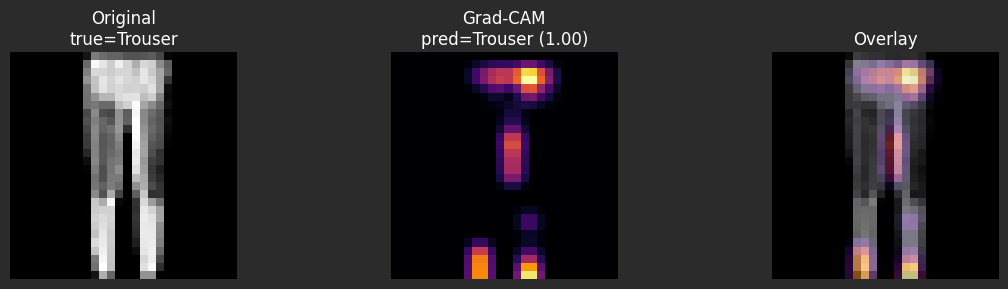

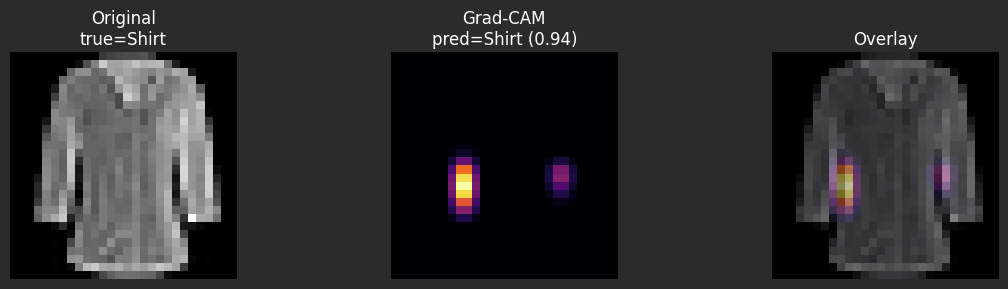

In [ ]:
show_gradcam_results(
    model_cpu=fashion_model_cpu,
    examples=fashion_examples,
    class_names=FASHION_MNIST_CLASS_NAMES,
    gradcam=gradcam_explainer,
)

### 4.2.5 Run Grad-CAM on incorrect examples

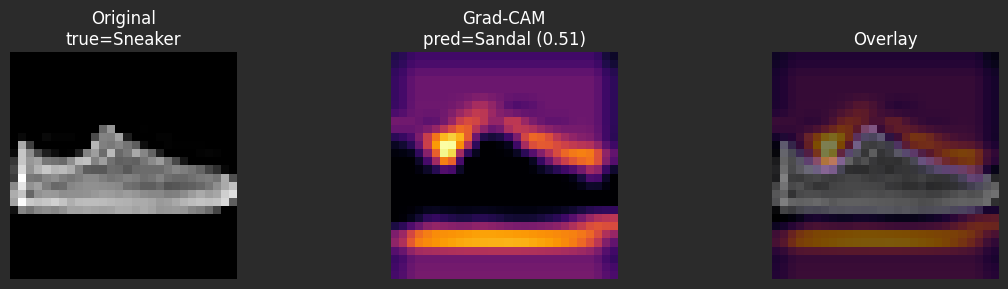

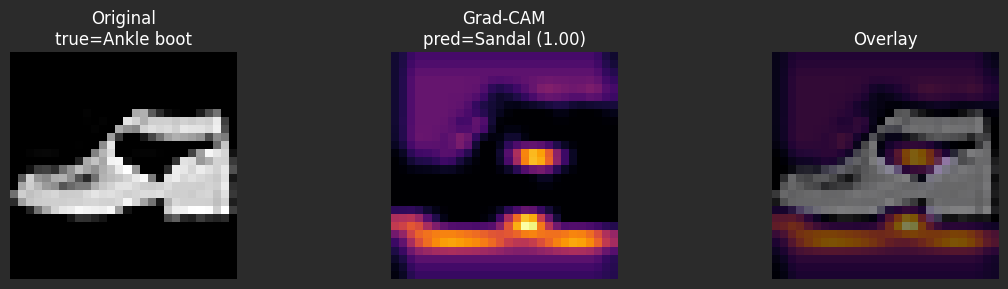

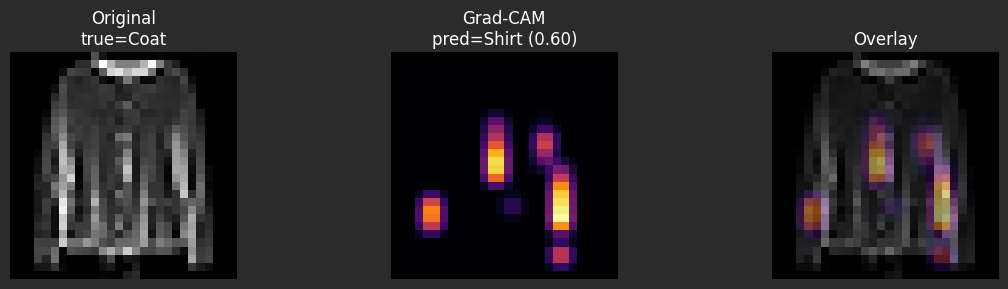

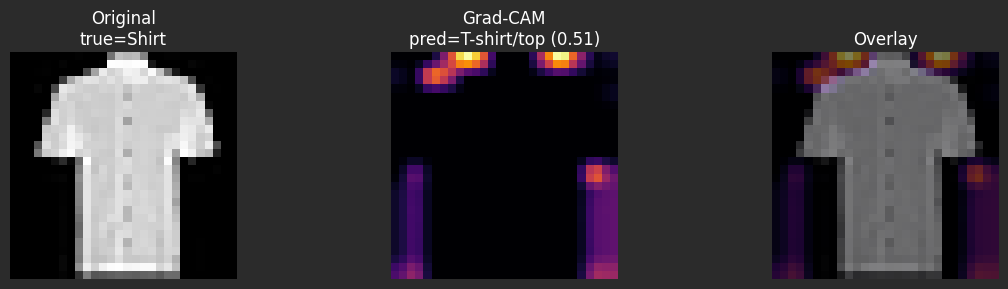

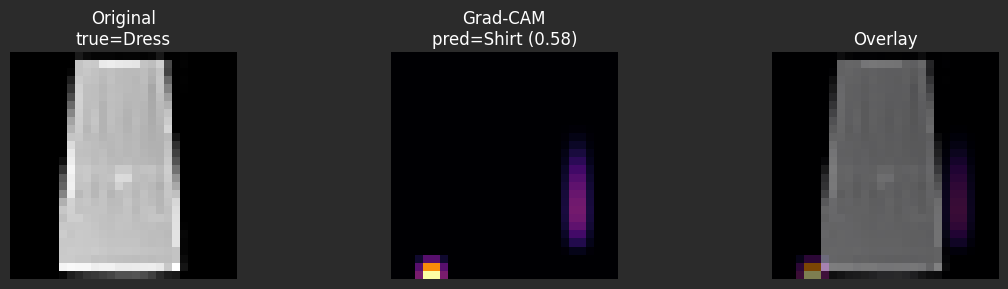

In [ ]:
show_gradcam_results(
    model_cpu=fashion_model_cpu,
    examples=fashion_misclassified_examples,
    class_names=FASHION_MNIST_CLASS_NAMES,
    gradcam=gradcam_explainer,
)

### 4.2.6 Grad-CAM — Results and conclusion

Grad-CAM highlights the **regions in the image that most influenced the CNN’s decision** by projecting class-specific importance back to the last convolutional feature maps. Compared to Integrated Gradients (pixel-level), Grad-CAM is **coarser** and typically focuses on larger, higher-level regions.

**Correct predictions:** For several correctly classified samples, the Grad-CAM maps concentrate on a few **high-activation patches** located on distinctive parts of the object (e.g., shoe sole/toe region, trouser leg/hem areas, and upper-torso regions for tops). This suggests the CNN relies on **discriminative “parts”** rather than evenly using the entire silhouette.

**Misclassifications:** The misclassified examples show Grad-CAM focusing on **shared cues between similar classes**, which helps explain the errors. For instance, footwear mistakes (Sneaker/Ankle boot → Sandal) show strong attention on the **bottom edge/sole line**, which is common across many shoe types at 28×28 resolution. For clothing confusions (Coat/Dress → Shirt), attention often concentrates on **upper-torso/central regions**, while cues that separate these classes (e.g., garment length or hem structure) are weak or not strongly highlighted.

**Overall takeaway:** Grad-CAM indicates that the CNN’s decisions are driven by a small set of **high-level discriminative regions**. When those regions are ambiguous (especially for visually similar categories in low resolution), the model can confidently attend to the “wrong” cue, leading to misclassification. This complements IG: IG shows fine-grained edge evidence, while Grad-CAM reveals the broader regions where the CNN is “looking” during its prediction.
